# MNIST Training on Dataset with idk labels: LeNet

Based on a Jupyter Notebook by Antonio Rueda-Toicen.

### Required Packages
FiftyOne, PyTorch, and several other packages are required. You can install them with:



In [1]:
%%capture
!uv pip install fiftyone==1.7.0 torch==2.6.0 torchvision==0.21 numpy==2.0.2

In [2]:
# Check installed versions
import fiftyone
import torch
import torchvision
import numpy
(fiftyone.__version__, torch.__version__,
 torchvision.__version__, numpy.__version__)

/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


('1.7.0', '2.6.0+cu124', '0.21.0+cu124', '2.0.2')

### **Content Overview**

Here is a breakdown of what we will perform in this notebook, split into two main parts. First, we will do active learning by building, training, and curating a dataset for a specialized supervised model, LeNet-5. This should result in a new curated MNIST dataset where unknown samples are labeled as "idk". Secondly, we will train a multi label classifier with the "idk" label as a further option.

### FiftyOne Plug-ins

We'll also install FiftyOne plugins for model evaluation and data augmentation:






In [3]:
# Plug-in to evaluate the performance of our classification models
!fiftyone plugins download \
    https://github.com/voxel51/fiftyone-plugins \
    --plugin-names @voxel51/evaluation


Copying plugin '@voxel51/evaluation' to '/root/fiftyone/__plugins__/@voxel51/evaluation'


In [4]:
# Plug-in for image augmentations
!fiftyone plugins download https://github.com/jacobmarks/fiftyone-albumentations-plugin


Copying plugin '@jacobmarks/albumentations_augmentation' to '/root/fiftyone/__plugins__/@jacobmarks/albumentations_augmentation'


## Imports

In [11]:
import os

# Set environment variables for reproducibility BEFORE importing torch
os.environ['PYTHONHASHSEED'] = '51'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Fun
import torchvision.transforms.v2 as transforms
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from torch.utils.data import Dataset, ConcatDataset
from fiftyone import ViewField as F
import fiftyone.utils.random as four
from tqdm import tqdm
from torch.optim import Adam
from pathlib import Path
import matplotlib.pyplot as plt
import gc
import albumentations as A
import cv2
import random
from typing import Optional, Dict, Tuple, Any
from datasets import load_dataset

In [12]:
hf = load_dataset("philippkolbe/mnist-curated-with-idk-labels")
hf

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/5.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [13]:
def hf_to_fiftyone(hf_split, name, export_dir="./fo_images"):
    """
    Converts a HuggingFace image dataset split to a FiftyOne dataset.

    Args:
        hf_split: HuggingFace Dataset split (e.g., hf["train"]).
        name: Name for the FiftyOne dataset.
        export_dir: Directory where images will be saved.

    Returns:
        FiftyOne Dataset object.
    """
    samples = []
    label_names = hf_split.features["label"].names

    # Create directory to store images for this dataset
    dataset_dir = os.path.join(export_dir, name)
    os.makedirs(dataset_dir, exist_ok=True)

    for idx, (img, label) in enumerate(zip(hf_split["image"], hf_split["label"])):
        # Save image as PNG
        img_path = os.path.join(dataset_dir, f"{idx}.png")
        img.convert("L").save(img_path)  # convert to grayscale just in case

        # Create FiftyOne Sample with filepath
        samples.append(
            fo.Sample(
                filepath=img_path,
                ground_truth=fo.Classification(label=label_names[label])
            )
        )

    # Create FiftyOne dataset
    dataset = fo.Dataset(name)
    dataset.add_samples(samples)
    return dataset

train_val_dataset = hf_to_fiftyone(hf["train"], "mnist-curated-trainval")
test_dataset = hf_to_fiftyone(hf["test"], "mnist-curated-test")

 100% |█████████████| 60000/60000 [33.5s elapsed, 0s remaining, 1.4K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 60000/60000 [33.5s elapsed, 0s remaining, 1.4K samples/s]      


 100% |█████████████| 10000/10000 [4.7s elapsed, 0s remaining, 1.7K samples/s]      


INFO:eta.core.utils: 100% |█████████████| 10000/10000 [4.7s elapsed, 0s remaining, 1.7K samples/s]      


In [14]:
session = fo.launch_app(train_val_dataset, auto=False)

Session launched. Run `session.show()` to open the App in a cell output.


INFO:fiftyone.core.session.session:Session launched. Run `session.show()` to open the App in a cell output.



Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.7.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.7.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Part 1: Supervised Fine-Tuning with LeNet-5

**Supervised fine-tuning with a convolutional neural network (CNN)**. We will build and train a LeNet-5 model from scratch on the MNIST training data. This will allow us to compare the performance of a task-specific supervised model against the zero-shot capabilities of a foundation model. Think of it as evaluating the knowledge of a generalist vs a super-specialized expert on a narrow subject matter.

Furthermore, we will leverage the insights gained from our initial data exploration and model evaluation to demonstrate an **iterative dataset curation workflow**. Using FiftyOne's capabilities, we will identify misclassified samples, analyze model uncertainty and mistakenness, and strategically apply data augmentation to improve our model's performance.

This second part will cover:

- Building and training a LeNet-5 model in PyTorch.
- Evaluating the LeNet-5 model's performance on the test set.
- Analyzing model predictions to identify problematic samples.
- Using FiftyOne to find mislabeled and hard samples in the training data.
- Applying data augmentation to improve the model's robustness.
- Retraining the model with the augmented dataset.
- Comparing the performance of the original and fine-tuned models.

By the end of this section, you will have a deeper understanding of supervised learning workflows, the power of data curation for model improvement, and how FiftyOne facilitates these processes.

## Reproducibility for Training Experiments

To ensure full reproducibility of your training experiments, you need to set random seeds for all libraries and operations that involve randomness. This ensures that initial model weights, data shuffling, and any other random operations are the same across different runs.



In [16]:
def set_seeds(seed=51):
    """
    Set seeds for complete reproducibility across all libraries and operations.

    Args:
        seed (int): Random seed value
    """
    # Set environment variables before other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU (all devices)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

        # CUDA deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # OpenCV
    cv2.setRNGSeed(seed)

    # Albumentations (for data augmentation)
    try:
        A.seed_everything(seed)
    except AttributeError:
        # Older versions of albumentations
        pass

    # PyTorch deterministic algorithms (may impact performance)
    try:
        torch.use_deterministic_algorithms(True)
    except RuntimeError:
        # Some operations don't have deterministic implementations
        print("Warning: Some operations may not be deterministic")

    print(f"All random seeds set to {seed} for reproducibility")



# Usage: Call this function at the beginning and before each training phase
set_seeds(51)

# Additional reproducibility considerations:

def create_deterministic_training_dataloader(dataset, batch_size, shuffle=True, **kwargs):
    """
    Create a DataLoader with deterministic behavior.

    Args:
        dataset: PyTorch Dataset instance
        batch_size: Batch size
        shuffle: Whether to shuffle data
        **kwargs: Additional DataLoader arguments

    Returns:
        Training DataLoader with reproducible behavior
    """
    # Use a generator with fixed seed for reproducible shuffling
    generator = torch.Generator()
    generator.manual_seed(51)

    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        generator=generator if shuffle else None,
        **kwargs
    )

# Example usage:
# train_loader = create_deterministic_dataloader(
#     torch_train_set,
#     batch_size=64,
#     shuffle=True,
#     num_workers=4,
#     pin_memory=True
# )



All random seeds set to 51 for reproducibility


## Creating a Custom Convolutional Neural Networks in PyTorch (Two Versions of LeNet-5)

![](https://raw.githubusercontent.com/andandandand/practical-computer-vision/refs/heads/main/images/lenet5-architecture.png)

While zero-shot classification with CLIP demonstrates the power of modern pre-trained models, understanding how to build and train convolutional neural networks from scratch remains fundamental to computer vision. **LeNet-5**, proposed by Yann LeCun in 1998, represents one of the earliest and most influential CNN architectures. Despite its age, LeNet-5 perfectly illustrates core CNN concepts including convolutional layers, pooling layers, and the transition from feature extraction to classification.

LeNet-5's architecture is elegantly simple yet effective: it uses alternating convolutional and pooling layers to extract hierarchical features, followed by fully connected layers for classification. The network learns low-level features like edges and curves in early layers, then combines these into higher-level digit patterns in deeper layers. This hierarchical feature learning principle underlies virtually all modern CNN architectures.

For MNIST digit classification, LeNet-5 provides an excellent baseline to compare against CLIP's zero-shot performance. While CLIP leverages massive-scale pre-training and vision-language understanding, LeNet-5 demonstrates what's possible with task-specific supervised learning on a much smaller scale. Building this model from scratch in PyTorch teaches essential concepts about gradient-based optimization, backpropagation, and the relationship between network architecture and learning capacity.



Here is [a great animation](https://youtu.be/UxIS_PoVoz8?si=3ibZms7Hk1oSj55k) showcasing the architecture.



In [17]:
class ClassicLeNet5(nn.Module):
    """
    LeNet-5 CNN architecture for MNIST digit classification.

    Original paper: "Gradient-Based Learning Applied to Document Recognition"
    by LeCun et al. (1998)

    Architecture (maintains original design with padding):
    Input (28x28) -> Pad to (32x32) -> C1 (6@28x28) -> S2 (6@14x14) ->
    C3 (16@10x10) -> S4 (16@5x5) -> C5 (120@1x1) -> F6 (84) -> Output (10)
    """

    def __init__(self, num_classes):
        super(ClassicLeNet5, self).__init__()

        # Feature extraction layers
        # C1: Convolutional layer - 6 feature maps, 5x5 kernels
        # Add padding=2 to convert 28x28 input to 32x32, maintaining original design
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)

        # S2: Subsampling layer (average pooling) - 2x2 with stride 2
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C3: Convolutional layer - 16 feature maps, 5x5 kernels
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)

        # S4: Subsampling layer (average pooling) - 2x2 with stride 2
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        # C5: Convolutional layer - 120 feature maps, 5x5 kernels (original design)
        # This reduces the 5x5 feature maps to 1x1
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)

        # Classification layers
        # F6: Fully connected layer with 84 units
        self.fc1 = nn.Linear(120, 84)

        # Output layer: 10 classes for digits 0-9
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x: Input tensor of shape (batch_size, 1, 28, 28)

        Returns:
            Output logits of shape (batch_size, num_classes)
        """
        # C1: Convolution + activation (padding converts 28x28 to 32x32, then conv to 28x28)
        # Input: (batch, 1, 28, 28) -> Pad to (32, 32) -> Conv to (batch, 6, 28, 28)
        x = torch.tanh(self.conv1(x))

        # S2: Average pooling
        # Input: (batch, 6, 28, 28) -> Output: (batch, 6, 14, 14)
        x = self.pool1(x)

        # C3: Convolution + activation
        # Input: (batch, 6, 14, 14) -> Output: (batch, 16, 10, 10)
        x = torch.tanh(self.conv2(x))

        # S4: Average pooling
        # Input: (batch, 16, 10, 10) -> Output: (batch, 16, 5, 5)
        x = self.pool2(x)

        # C5: Convolution + activation (original 5x5 kernel design)
        # Input: (batch, 16, 5, 5) -> Output: (batch, 120, 1, 1)
        x = torch.tanh(self.conv3(x))

        # Flatten for fully connected layers
        # Input: (batch, 120, 1, 1) -> Output: (batch, 120)
        x = x.view(x.size(0), -1)

        # F6: Fully connected + activation
        # Input: (batch, 120) -> Output: (batch, 84)
        x = torch.tanh(self.fc1(x))

        # Output layer (no activation - raw logits)
        # Input: (batch, 84) -> Output: (batch, 10)
        x = self.fc2(x)

        return x

Below is an alternative and more modern implementation. Here the activation functions have been switched from tanh to ReLU and Max Pooling is used instead of Average Pooling. Feel free to choose either!

These networks are trained from scratch. We will use train portion of the MNIST dataset to do this.

In [18]:
# Alternative modern version with ReLU and MaxPooling
class ModernLeNet5(nn.Module):
    """
    Modernized version of LeNet-5 with ReLU activations and max pooling.
    Often performs better on MNIST than the original version.
    """

    def __init__(self, num_classes):
        super(ModernLeNet5, self).__init__()

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=4)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(Fun.relu(self.conv1(x)))
        x = self.pool(Fun.relu(self.conv2(x)))
        x = Fun.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = Fun.relu(self.fc1(x))
        x = self.dropout(x)  # Add dropout for regularization
        x = self.fc2(x)

        return x


## Splitting into Train and Validation

The **validation set** serves as an unbiased evaluation mechanism during model development, acting as a proxy for real-world performance before touching the final test set. While the training set teaches the model to recognize patterns in handwritten digits, the validation set reveals whether the model has truly learned generalizable features or simply memorized the training data, a phenomenon known as overfitting.

During training, we monitor both training and validation **loss** simultaneously. **Loss** is a numerical measure of how far off the model's predictions are from the correct answers - lower loss means better performance. We use categorical cross-entropy loss, which penalizes confident wrong predictions more heavily than uncertain ones. **Training loss** typically decreases steadily as the model learns, but **validation loss** tells the real story. If validation loss plateaus or begins increasing while training loss continues decreasing, the model is overfitting and memorizing training-specific details rather than learning robust digit recognition patterns. This signals when to stop training, adjust hyperparameters, or modify the architecture.

The validation set also enables **hyperparameter tuning** without contaminating our final evaluation. We can experiment with different learning rates, batch sizes, regularization techniques, or architectural modifications, using validation loss to guide these decisions. Each configuration gets evaluated on the same held-out validation data, ensuring fair comparisons.

**Important: the test set remains completely untouched** throughout the development process. Only after we've selected our final model configuration based on validation performance do we evaluate on the test set once, giving us an honest estimate of how the model will perform on truly unseen data. This three-way split (train/validation/test) is fundamental to responsible machine learning development and prevents the subtle "data leakage" that can make models appear better than they actually are.

In [19]:
set_seeds(51)
# Create random 85%/15% split using tags
four.random_split(train_val_dataset,
                  {"train": 0.85, "validation": 0.15},
                  # The seed makes the split reproducible
                  seed=51)

# Verify the split by counting tags
tag_counts = train_val_dataset.count_sample_tags()
print("Tag counts after split:")
print(tag_counts)

# Separate validation and train FO datasets
train_dataset = train_val_dataset.match_tags("train").clone()
val_dataset = train_val_dataset.match_tags("validation").clone()

# Set names for FO datasets using the 'name' property
train_dataset.name = "mnist-curated-train"
val_dataset.name = "mnist-curated-validation"

# Define persistency
train_dataset.persistent = True
val_dataset.persistent = True

# Verify no overlap between train and validation
train_ids = set(train_dataset.values("id"))
val_ids = set(val_dataset.values("id"))
overlap = train_ids.intersection(val_ids)

All random seeds set to 51 for reproducibility
Tag counts after split:
{'train': 51000, 'validation': 9000}


## Moving the FiftyOne Data Splits to torch Datasets

To train our PyTorch model, we need to convert our FiftyOne dataset views into PyTorch `Dataset` objects that can load and preprocess images during training. This bridge between FiftyOne's dataset management and PyTorch's training pipeline is important for maintaining both the metadata and annotations while enabling batch processing. PyTorch's `Dataset` class provides a standardized interface for data loading, handling tasks like image loading, preprocessing transforms, and label conversion. By creating a custom dataset class that works with FiftyOne's file paths and labels, we can leverage PyTorch's `DataLoader` for batching, shuffling, and parallel data loading while preserving all the dataset analysis capabilities that FiftyOne provides. This approach allows us to move between FiftyOne's visual analysis and PyTorch's training workflows without duplicating data or losing the rich metadata we've computed.

In [20]:
# Custom PyTorch Dataset class for MNIST training data
class CustomTorchImageDataset(torch.utils.data.Dataset):
    def __init__(self, fiftyone_dataset,
                 label_map,
                 image_transforms=None,
                 gt_field="ground_truth"):
        self.fiftyone_dataset = fiftyone_dataset
        self.image_paths = self.fiftyone_dataset.values("filepath")
        self.str_labels = self.fiftyone_dataset.values(f"{gt_field}.label")
        self.image_transforms = image_transforms
        self.label_map = label_map

        print(f"CustomTorchImageDataset initialized with {len(self.image_paths)} samples.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        try:
            image = Image.open(image_path).convert('L')
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            return torch.randn(1, 28, 28), torch.tensor(-1, dtype=torch.long)

        if self.image_transforms:
            image = self.image_transforms(image)

        label_str = self.str_labels[idx]
        label_idx = self.label_map.get(label_str, -1)
        if label_idx == -1:
            print(f"Warning: Label '{label_str}' not in label_map for image {image_path}")

        return image, torch.tensor(label_idx, dtype=torch.long)

## Computing the Mean and Standard Deviation

Before training neural networks, we compute the **mean and standard deviation** of our input data to apply **standard scaling** (also called normalization or standardization).


**Standard Scaling Formula:**

$$z = \frac{x - \mu}{\sigma}$$

Where:
- $z$ = standardized value
- $x$ = original pixel value
- $\mu$ = mean of all pixel values in the dataset
- $\sigma$ = standard deviation of all pixel values in the dataset

In PyTorch, this is implemented with torch.`transforms.Normalize((mean_intensity), (std_intensity))`

This preprocessing step transforms our pixel values to have zero mean and unit variance, which provides several critical benefits:

**Why Standard Scaling Matters:**

**Gradient Optimization**: Neural networks learn through gradient descent, which works best when input features are on similar scales. Without scaling, features with larger magnitudes (like raw pixel values 0-255) can dominate the gradient updates, leading to slower convergence and unstable training.

**Weight Initialization Compatibility**: Modern weight initialization schemes (Xavier, He initialization) assume inputs are roughly centered around zero with unit variance. Standard scaling ensures our data matches these assumptions, preventing vanishing or exploding gradients during early training.

**Activation Function Efficiency**: Many activation functions (tanh, sigmoid) work optimally when inputs are centered around zero. Scaled inputs help neurons operate in the most responsive regions of these functions rather than saturating in flat regions.

**Learning Rate Stability**: With standardized inputs, we can use higher learning rates without instability, as the optimization landscape becomes more uniform across different dimensions.

For MNIST images, we transform raw pixel values from the range [0, 255] to approximately [-1, 1] with mean ≈ 0, creating a more favorable training environment that typically results in faster convergence and better final performance.


In [21]:
def compute_stats_fiftyone(fiftyone_view):
    """
    Compute stats directly from FiftyOne using aggregations.
    Requires images to be loaded as arrays.
    """

    print("Computing image intensity statistics from FiftyOne view...")

    # Get all image filepaths
    filepaths = fiftyone_view.values("filepath")

    # Load all pixel values
    all_pixels = []

    for filepath in tqdm(filepaths):

        try:
            # Load image as grayscale array
            image = Image.open(filepath).convert('L')
            # Scale values to the range [0, 1]
            pixels = np.array(image, dtype=np.float32) / 255.0
            all_pixels.append(pixels.flatten())
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
            continue

    # Concatenate all pixel values
    all_pixels = np.concatenate(all_pixels)

    # Compute statistics
    mean = np.mean(all_pixels)
    std = np.std(all_pixels)

    print(f"Computed from {len(filepaths)} images")
    print(f"Total pixels: {len(all_pixels):,}")

    return mean, std

mean_intensity, std_intensity = compute_stats_fiftyone(train_dataset)
f"Mean: {mean_intensity:.4f}, Std: {std_intensity:.4f}"

Computing image intensity statistics from FiftyOne view...


100%|██████████| 51000/51000 [00:08<00:00, 5681.57it/s]


Computed from 51000 images
Total pixels: 39,984,000


'Mean: 0.1317, Std: 0.3074'

In [22]:
# We obtain the distinct labels of the dataset
dataset_classes = sorted(train_dataset.distinct("ground_truth.label"))
dataset_classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine',
 'idk']

In [23]:
# Map the string labels to numerical values (we need this for the PyTorch dataset)
label_map = {string_label: index for index, string_label in enumerate(dataset_classes)}
label_map

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9,
 'idk': 10}

Transform the PIL images into PyTorch tensors with scaling based on stats from the training set.

In [24]:
image_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize((mean_intensity,), (std_intensity,))
])

In [25]:
torch_train_set = CustomTorchImageDataset(train_dataset,
                                          label_map=label_map,
                                          image_transforms=image_transforms)

CustomTorchImageDataset initialized with 51000 samples.


In [26]:
torch_val_set = CustomTorchImageDataset(val_dataset,
                                     label_map=label_map,
                                     image_transforms=image_transforms)

CustomTorchImageDataset initialized with 9000 samples.


In [27]:
# Create a PyTorch Dataset for the test set
torch_test_set = CustomTorchImageDataset(test_dataset,
                                      label_map=label_map, # Use the same label map as training
                                      image_transforms=image_transforms) # Use the same transforms

CustomTorchImageDataset initialized with 10000 samples.


### Create PyTorch DataLoaders

DataLoaders wrap our custom datasets and handle the mechanics of training: batching samples together, shuffling data between epochs, and loading images in parallel using multiple CPU cores. The batch size determines how many images the model processes at once, affecting both memory usage and training dynamics. We shuffle the training data to prevent the model from learning spurious patterns based on sample order, but keep validation data unshuffled since evaluation order doesn't matter. Parallel loading with multiple workers speeds up training by preparing the next batch while the GPU processes the current one.



In [28]:
# Define batch size (you can adjust this based on your GPU memory)
batch_size = 64
num_workers = os.cpu_count()  # Number of CPU cores

In [29]:
from collections import Counter
import torch

# Convert string labels to integer labels
int_labels = [label_map[l] for l in train_dataset.values("ground_truth.label")]

# Count samples per class
class_counts = Counter(int_labels)
print(class_counts)

Counter({1: 5703, 7: 5326, 3: 5205, 2: 5093, 9: 5024, 6: 5002, 0: 4989, 8: 4968, 4: 4934, 5: 4548, 10: 208})


In [30]:
# Weight for each class = 1 / num_samples_in_class
class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}

# Assign weight to each sample
sample_weights = [class_weights[label] for label in int_labels]
sample_weights = torch.DoubleTensor(sample_weights)
class_weights

{0: 0.00020044097013429546,
 1: 0.0001753463089601964,
 2: 0.00019634792852935403,
 3: 0.00019212295869356388,
 4: 0.00020267531414673692,
 5: 0.00021987686895338611,
 6: 0.00019992003198720512,
 7: 0.0001877581674802854,
 8: 0.00020128824476650564,
 9: 0.00019904458598726116,
 10: 0.004807692307692308}

In [31]:
from torch.utils.data import WeightedRandomSampler

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [32]:
train_loader = create_deterministic_training_dataloader(
    torch_train_set,
    batch_size=64,
    num_workers=num_workers,
    pin_memory=True,
    sampler=sampler,
    shuffle=False, # use custom sampler
)

In [33]:
val_loader = torch.utils.data.DataLoader(
    torch_val_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=num_workers,
    pin_memory=True
)

In [34]:
test_loader = torch.utils.data.DataLoader(
    torch_test_set,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle test data
    num_workers=num_workers,
    pin_memory=True
)

In [35]:
print("Train and validation DataLoaders created successfully.")
print(f"Train DataLoader has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")
print(f"Test DataLoader has {len(test_loader)} batches.")

Train and validation DataLoaders created successfully.
Train DataLoader has 797 batches.
Validation DataLoader has 141 batches.
Test DataLoader has 157 batches.


## Instantiate the Loss Function (Categorical Cross Entropy)

**Categorical Cross Entropy** is the standard loss function for multi-class classification problems like MNIST digit recognition. It measures how far our model's predicted probability distribution is from the true distribution (one-hot encoded labels).

**Mathematical Formula:**
$$\text{CCE} = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)$$

Where:
- $C$ = number of classes (10 for MNIST digits 0-9)
- $y_i$ = true label (1 for correct class, 0 for others)
- $\hat{y}_i$ = predicted probability for class $i$

**Intuitions about Cross Entropy Loss**: The loss encourages the model to output high confidence (probability close to 1.0) for the correct class and low confidence for incorrect classes.

For a perfectly correct prediction (probability = 1.0 for true class), the loss approaches 0 and gradients are small (meaning that there is little change on weights). For very wrong predictions (probability = 0.001 for the ground truth class), the loss approaches infinity, strongly penalizing confident mistakes and forcing the neural network to update its weights.

PyTorch implements a numerically stable variant of CCE based on the LogSoftMax function. You can read more about it [here](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [36]:
ce_loss = nn.CrossEntropyLoss()

## Prepare Training and Validation for our Custom Model

We define two functions to handle the training and validation phases of each epoch. The `train_epoch()` function puts the model in training mode, processes batches through forward passes, computes loss, and updates weights via backpropagation.

In [37]:
def train_epoch(model, train_loader):
  batch_losses = []
  model.train()
  for images, labels in tqdm(train_loader, desc="Training: "):
      #import pdb; pdb.set_trace()

      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)
      # Clear gradients from previous iteration (PyTorch accumulates by default)
      optimizer.zero_grad()
      # Computes the gradients with backpropagation
      loss_value.backward()
      # Updates the weights
      optimizer.step()

      batch_losses.append(loss_value.item())

  train_loss = np.mean(batch_losses)
  return train_loss


The `val_epoch()` function switches the model to evaluation mode and computes validation loss without updating weights, giving us an unbiased measure of performance on held-out data. These functions return the average loss across all batches, which we'll track to monitor training progress and detect overfitting.

In [38]:
def val_epoch(model, val_loader):
  batch_losses = []
  model.eval()
  with torch.inference_mode():
    for images, labels in tqdm(val_loader, desc="Validation: "):
      images = images.to(device)
      labels = labels.to(device)
      # Forward pass
      logits = model(images)
      loss_value = ce_loss(logits, labels)
      batch_losses.append(loss_value.item())
  val_loss = np.mean(batch_losses)
  return val_loss

## Defining the Optimizer

**Configuring the Learning Algorithm**

The optimizer determines how the neural network updates its weights based on computed gradients during training. This choice affects training speed, stability, and final model performance.

**Adam (Adaptive Moment Estimation)** is a variant of gradient descent that maintains running averages of both gradients and their squared values, allowing us to adapt the learning rate based on the historical behavior of each weight.

```python
optimizer = Adam(model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)
```

The learning rate (lr=0.003) controls the step size for weight updates, while the beta settings control how much history to consider when computing the adaptive rates. This configuration provides stable training for most computer vision tasks.


In [39]:
model = ModernLeNet5(num_classes=len(label_map)).to(device)

# Define the optimizer (variant of stochastic gradient descent)
optimizer = Adam(model.parameters(),
                 lr=0.003, betas=(0.9, 0.999),
                 eps=1e-08, weight_decay=0)


## Training and Checkpointing the Model

**Iterative Learning with Performance Monitoring**

Training a neural network involves showing the model batches of data, computing prediction errors, and updating weights to minimize those errors. This process continues for multiple epochs, where each epoch represents one complete pass through the entire training dataset.

**The Role of Validation-Based Checkpointing**

During training, we monitor performance on both training and validation sets. Training loss decreases as the model learns, but validation loss reveals the true generalization capability. The validation set acts as a proxy for real-world performance since the model never sees these samples during weight updates.

We save model checkpoints based on validation performance rather than training performance to prevent overfitting. A model might achieve low training loss by memorizing training examples, but this doesn't guarantee good performance on new data. By saving the model weights that achieve the best validation loss, we capture the point where the model has learned generalizable patterns without overfitting to training-specific details.

```python
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    torch.save(best_model.state_dict(), model_save_path)
    print('Found and saved better weights for the model')
```

This checkpointing strategy ensures we retain the model configuration that will perform best on unseen test data, even if training continues and validation performance later degrades due to overfitting.

In [40]:
# Ensure reproducibility for the training process
set_seeds(99) # You can change this number to get different results

num_epochs = 10
train_losses = []
val_losses = []

best_val_loss = float('inf')
best_model = None

# Define the path to save the model within your hard-drive
path = Path(os.getcwd()) # Feel free to change the path

model_save_path = path / 'best_lenet.pth'

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader)
    val_loss = val_epoch(model, val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)


    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        # Save the best model
        torch.save(best_model.state_dict(), model_save_path)
        print('Found and saved better weights for the model')

All random seeds set to 99 for reproducibility


Validation: 100%|██████████| 141/141 [00:07<00:00, 18.87it/s]


Epoch 1/10 - Train Loss: 0.4040 - Val Loss: 0.1621
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:05<00:00, 24.06it/s]


Epoch 2/10 - Train Loss: 0.1591 - Val Loss: 0.1147
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:04<00:00, 31.05it/s]


Epoch 3/10 - Train Loss: 0.1051 - Val Loss: 0.1224


Validation: 100%|██████████| 141/141 [00:04<00:00, 29.78it/s]


Epoch 4/10 - Train Loss: 0.0817 - Val Loss: 0.1253


Validation: 100%|██████████| 141/141 [00:05<00:00, 24.63it/s]


Epoch 5/10 - Train Loss: 0.0675 - Val Loss: 0.1118
Found and saved better weights for the model


Validation: 100%|██████████| 141/141 [00:06<00:00, 21.43it/s]


Epoch 6/10 - Train Loss: 0.0529 - Val Loss: 0.1369


Validation: 100%|██████████| 141/141 [00:05<00:00, 24.13it/s]


Epoch 7/10 - Train Loss: 0.0608 - Val Loss: 0.1385


Validation: 100%|██████████| 141/141 [00:05<00:00, 23.52it/s]


Epoch 8/10 - Train Loss: 0.0524 - Val Loss: 0.1353


Validation: 100%|██████████| 141/141 [00:04<00:00, 30.89it/s]


Epoch 9/10 - Train Loss: 0.0423 - Val Loss: 0.1505


Validation: 100%|██████████| 141/141 [00:06<00:00, 22.16it/s]

Epoch 10/10 - Train Loss: 0.0451 - Val Loss: 0.1801


## Visualizing Training vs Validation Losses

Plotting training and validation loss over epochs provides insights into model learning dynamics. These curves reveal whether the model is learning, overfitting, or underfitting the data.
In healthy training, both curves decrease together, with training loss lower than validation loss. When training loss continues decreasing while validation loss plateaus or increases, this indicates overfitting where the model memorizes training data rather than learning generalizable patterns. If both curves plateau at high values, the model may be underfitting and require more capacity (e.g.more layers or more weights) or more training epochs.

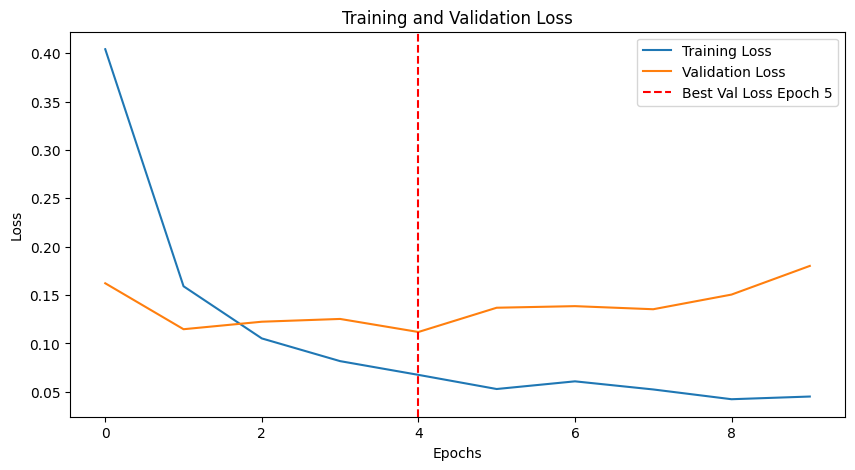

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Find the epoch with the best validation loss
best_epoch = np.argmin(val_losses)

# Add a vertical red line at the epoch with the best validation loss
plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Val Loss Epoch {best_epoch + 1}')
plt.legend()

plt.show()

## Reload the Best LeNet Model Weights

After training completes, we need to load the saved model weights that achieved the best validation performance. This ensures we use the model configuration that generalizes best to unseen data, rather than the final training state which may have overfitted.
The reloading process involves creating a new model instance with the same architecture, then loading the saved state dictionary containing the optimal weights. We must ensure the model is moved to the correct device (CPU or GPU) and set to evaluation mode for inference.

In [42]:
# Define the path where the best model was saved
path = Path(os.getcwd())
model_save_path = path / 'best_lenet.pth'

# Instantiate a new model with the same architecture
# Make sure you use the same model class that was trained
loaded_model = ModernLeNet5(num_classes=len(label_map))

# Load the saved state dictionary into the new model instance
# Make sure the model is on the correct device (CPU or GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_model.load_state_dict(torch.load(model_save_path, map_location=device))

# Move the model to the device
loaded_model = loaded_model.to(device)

# Set the model to evaluation mode
loaded_model.eval()

print(f"Model loaded successfully from {model_save_path}")
print(f"Model is on device: {next(loaded_model.parameters()).device}")

Model loaded successfully from /content/best_lenet.pth
Model is on device: cpu


## Apply our Custom Model to the Test Set

We have trained our LeNet-5 model and need to apply it to the test set to generate predictions and evaluate its performance. This step bridges the gap between PyTorch training and FiftyOne's analysis capabilities.

**Why Store Predictions as FiftyOne Classifications?**

Instead of storing raw predictions as strings or numbers, we use FiftyOne's [`Classification`](https://docs.voxel51.com/api/fiftyone.core.labels.html#fiftyone.core.labels.Classification) objects, which provide several key advantages:

**Structured Data Storage**: Classification objects encapsulate the predicted label, confidence score, and raw logits in a standardized format that FiftyOne understands.

**Evaluation Integration**: FiftyOne's evaluation framework (`evaluate_classifications()`) can compare Classification objects against ground truth labels, generating metrics like confusion matrices, per-class accuracy, and performance reports.

**Querying and Filtering**: With Classification objects, we can filter samples by confidence thresholds, find misclassifications, or identify uncertain predictions using FiftyOne's query language:

```python
# Find high-confidence predictions
high_conf = dataset.match(F("predictions.confidence") > 0.95)

# Find misclassifications  
errors = dataset.match(F("predictions.label") != F("ground_truth.label"))
```

**Visual Analysis**: The FiftyOne App can visualize Classification objects with confidence scores, making it simple to spot patterns in model behavior and identify errors.

**Model Comparison**: Storing predictions in this standardized format enables comparison between different models (like our LeNet vs. CLIP's zero-shot classification) using the same evaluation framework.

**Confidence-Based Analysis**: The embedded confidence scores allow for analysis like identifying samples where the model is uncertain, which correspond to edge cases or potential labeling errors in the dataset.

This approach transforms raw model outputs into queryable metadata that integrates with FiftyOne's computer vision workflow, enabling insights into model performance and behavior.

In [43]:
## Apply best_model to the test set, store logits and confidence

print(f"Test DataLoader has {len(test_loader)} batches.")

# Set the loaded model to evaluation mode
loaded_model.eval()

# Lists to store predictions and logits
predictions = []
all_logits = []

# Run inference on the test set
print("Applying best LeNet model to the test set...")
with torch.inference_mode(): # Disable gradient calculation
    for images, _ in tqdm(test_loader):
        images = images.to(device)

        # Forward pass to get logits
        logits = loaded_model(images)
        all_logits.append(logits.cpu().numpy()) # Store logits

        # Get predicted class indices
        _, predicted = torch.max(logits.data, 1)
        predictions.extend(predicted.cpu().numpy()) # Store predictions

# Concatenate logits from all batches
all_logits = np.concatenate(all_logits, axis=0)

print("Inference on test set complete.")
print(f"Shape of collected logits: {all_logits.shape}")
print(f"Number of collected predictions: {len(predictions)}")

# Store the predictions and logits back into the FiftyOne dataset as Classification objects
print("Storing predictions and logits as FiftyOne Classifications...")

for i, sample in enumerate(test_dataset):
    # Get the predicted class index and corresponding class name
    predicted_idx = predictions[i]
    predicted_label = dataset_classes[predicted_idx]

    # Get logits for this sample
    sample_logits = all_logits[i]

    # Calculate confidence scores (softmax applied to logits)
    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])

    # Create FiftyOne Classification object with prediction
    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()  # Store raw logits
    )

    # Store the Classification object in the sample
    sample["lenet_classification"] = classification

    sample.save()




Test DataLoader has 157 batches.
Applying best LeNet model to the test set...


100%|██████████| 157/157 [00:09<00:00, 16.06it/s]


Inference on test set complete.
Shape of collected logits: (10000, 11)
Number of collected predictions: 10000
Storing predictions and logits as FiftyOne Classifications...


### Verify the Stored Data Structure for Predictions
We should see `Classification` objects with label, confidence, and logits fields. We need these to perform analytics on our FiftyOne dataset.


In [44]:
print("\n=== Verification ===")
sample = test_dataset.first()
print(f"Sample prediction type: {type(sample.lenet_classification)}")
print(f"Sample prediction: {sample.lenet_classification}")
print(f"Prediction label: {sample.lenet_classification.label}")
print(f"Prediction confidence: {sample.lenet_classification.confidence}")
print(f"Prediction logits shape: {len(sample.lenet_classification.logits)}")

session.refresh()
print(f"\nFiftyOne App URL: {session.url}")




=== Verification ===
Sample prediction type: <class 'fiftyone.core.labels.Classification'>
Sample prediction: <Classification: {
    'id': '692221374ad8ea1d8ca95fd0',
    'tags': [],
    'label': '0 - zero',
    'confidence': 1.0,
    'logits': array([ 24.07928467, -29.97328377,  -4.89534807, -19.87263489,
           -27.25390053, -13.42123032,  -9.6866312 , -21.01004601,
            -5.70107555, -18.42669106,   2.65829611]),
}>
Prediction label: 0 - zero
Prediction confidence: 1.0
Prediction logits shape: 11

FiftyOne App URL: https://5151-m-s-34qmbw7p4vnk8-c.us-central1-0.prod.colab.dev?polling=true


### Create a View Showing only LeNet's Mistakes

The FiftyOne `Classification` object allows to do filtering on the samples where we have issues.


In [90]:
# Create a view showing only LeNet's misclassifications
misclassified_view = test_dataset.match(
    F("lenet_classification.label") != F("ground_truth.label")
)
print(f"Misclassified samples: {len(misclassified_view)} samples")
session.view = misclassified_view
session.refresh()
print(session.url)

Misclassified samples: 211 samples
https://5151-m-s-34qmbw7p4vnk8-c.us-central1-0.prod.colab.dev?polling=true


## Evaluating LeNet's Classification Performance

After applying our trained LeNet model to the test set, we need to evaluate its performance against the ground truth labels. This evaluation goes beyond simple accuracy to provide detailed insights into where and how the model succeeds or fails.
FiftyOne's evaluation framework generates metrics including per-class precision, recall, and F1-scores, along with confusion matrices that reveal which digit pairs the model most often confuses. This analysis helps identify weaknesses and guides future improvements.



In [89]:
lenet_evaluation_results = test_dataset.evaluate_classifications(
    "lenet_classification",
    gt_field="ground_truth",
    eval_key="lenet_eval")

https://5151-m-s-34qmbw7p4vnk8-c.us-central1-0.prod.colab.dev?polling=true


In [47]:
lenet_evaluation_results.print_report(digits=3)

              precision    recall  f1-score   support

    0 - zero      0.986     0.999     0.992       976
     1 - one      0.994     0.988     0.991      1128
     2 - two      0.978     0.991     0.984      1022
   3 - three      0.975     0.995     0.985      1002
    4 - four      0.982     0.974     0.978       974
    5 - five      0.979     0.991     0.985       884
     6 - six      0.990     0.977     0.984       949
   7 - seven      0.978     0.983     0.981      1013
   8 - eight      0.990     0.979     0.984       972
    9 - nine      0.976     0.981     0.979      1000
         idk      0.167     0.100     0.125        80

    accuracy                          0.979     10000
   macro avg      0.909     0.905     0.906     10000
weighted avg      0.976     0.979     0.978     10000



In [48]:
lenet_evaluation_results.plot_confusion_matrix()

/usr/local/lib/python3.12/dist-packages/fiftyone/core/plots/plotly.py:1591: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.

/usr/local/lib/python3.12/dist-packages/kaleido/_sync_server.py:11: UserWarning:




This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.




Does not work great for predicting idk samples. But the support is very small since we have so little. Model also samples some of the other numbers as "idk". Some of them could actually be relabeled as "idk" if we want to continue with active learning:
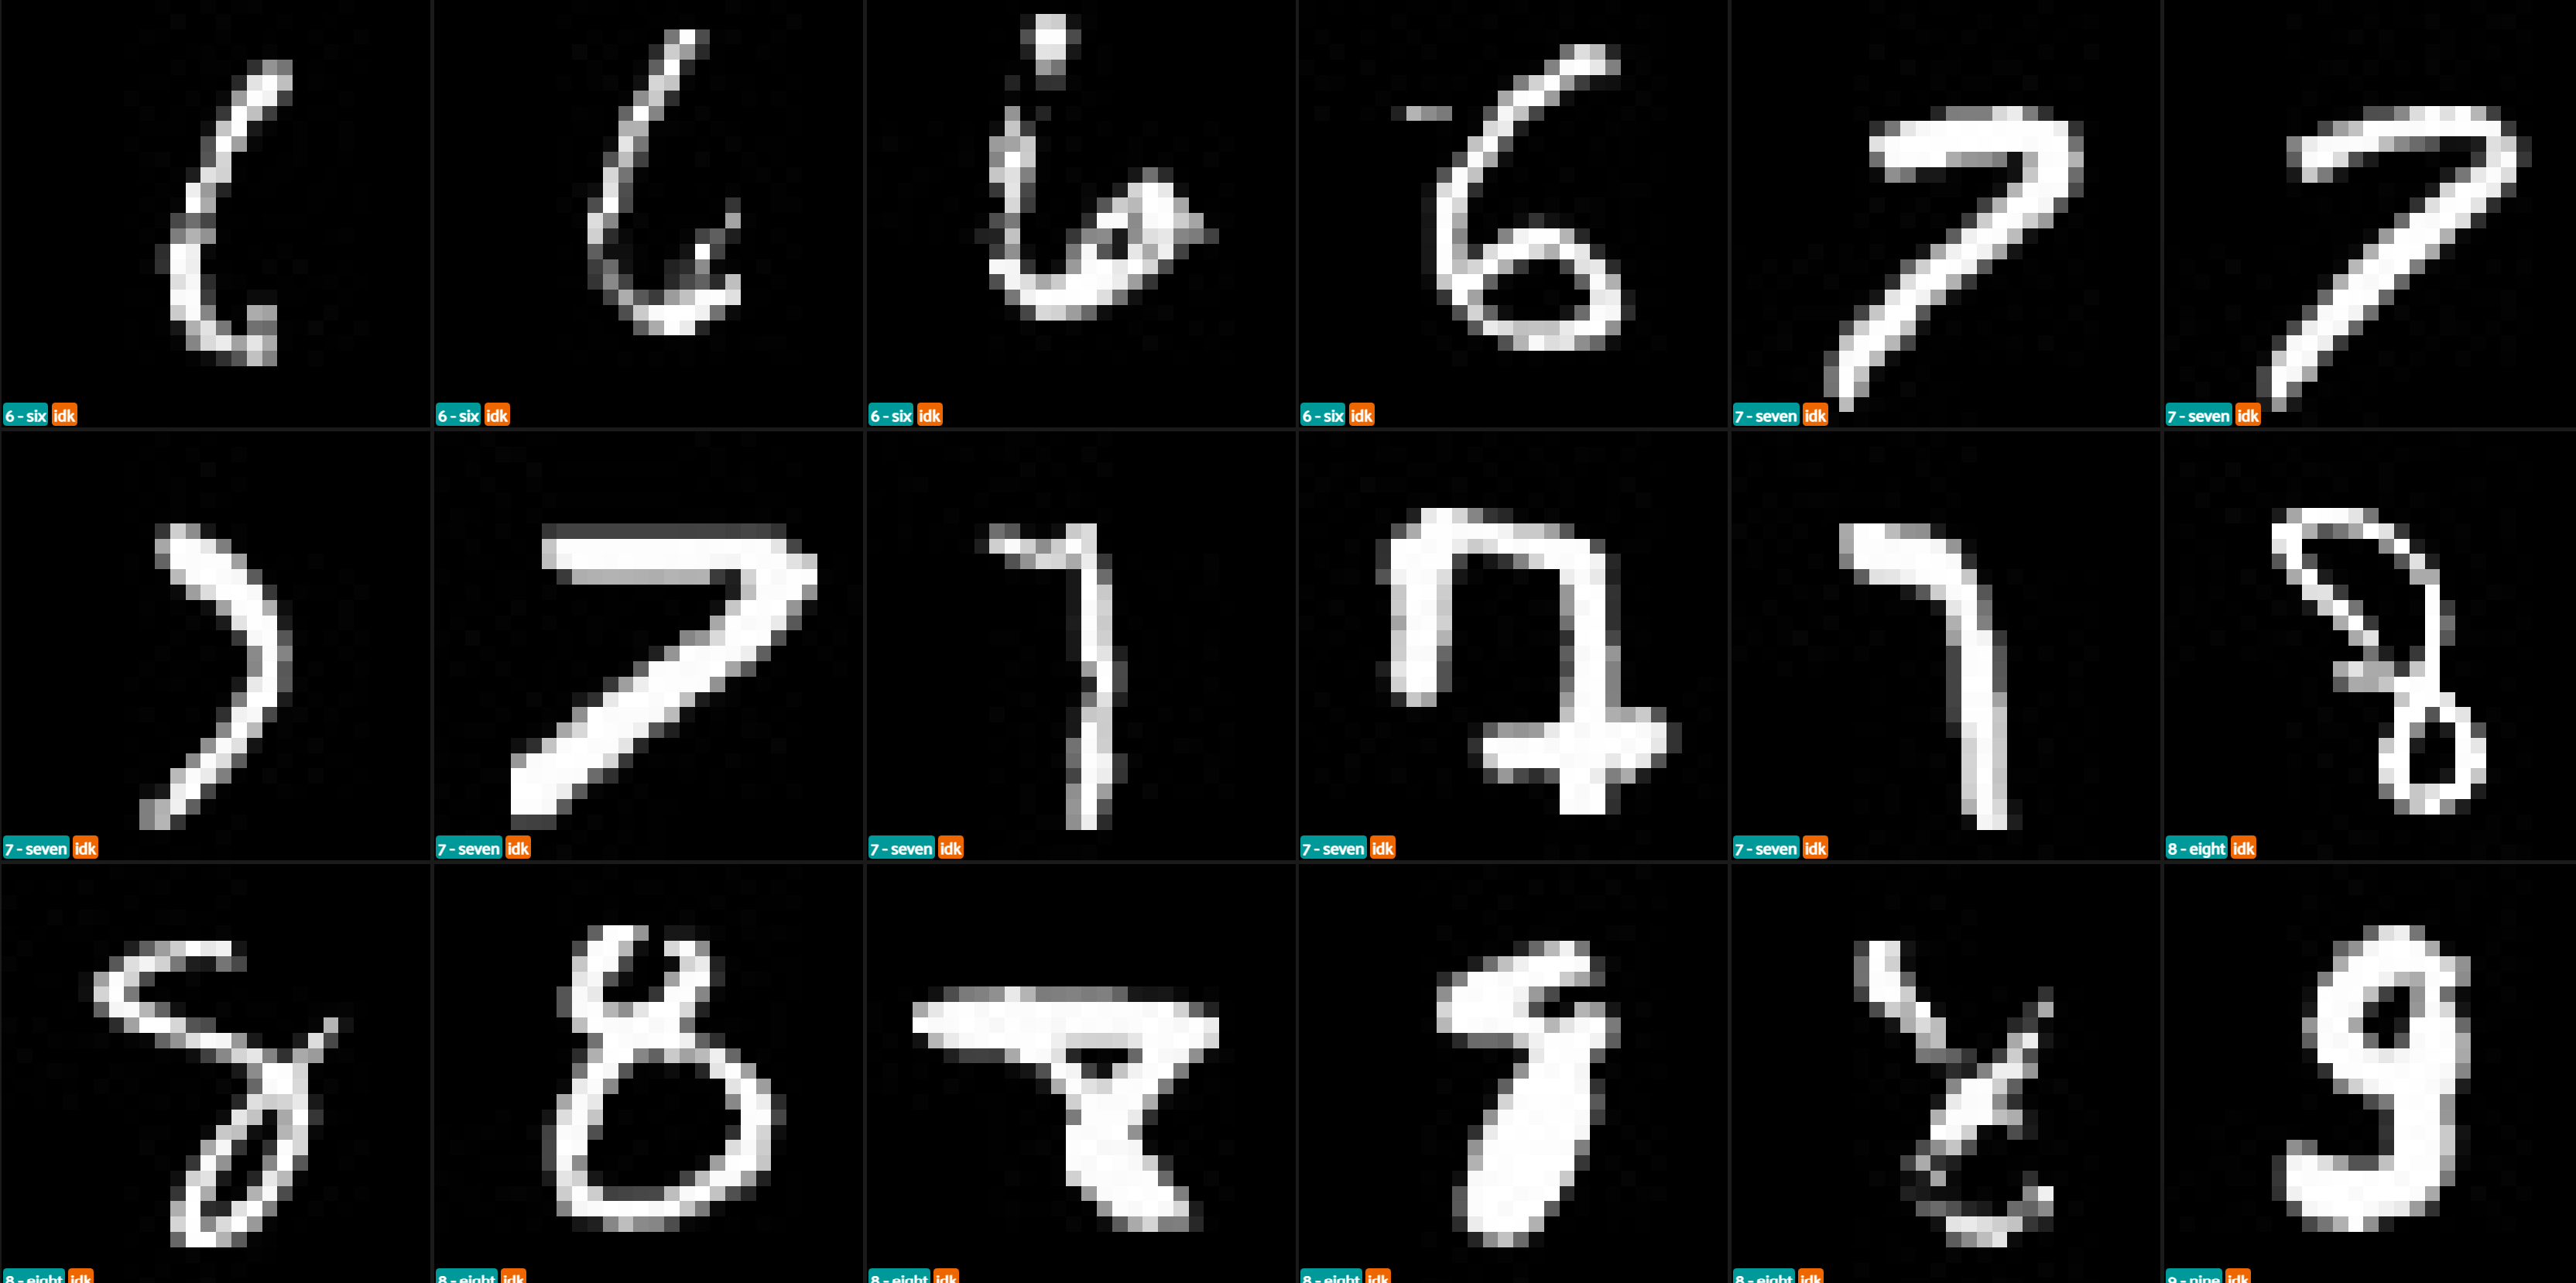

## Define Augmentations

**Configuring Transformations for MNIST Digit Recognition**

Data augmentation applies controlled transformations to training images, creating variations that help models generalize to new handwriting styles. For MNIST, effective augmentations simulate natural variations in digit writing without changing the digit's identity.

**Seeding for Reproducibility**: Set random seeds before defining augmentations to ensure consistent results across training runs. This enables reproducible experiments and fair model comparisons.

**MNIST-Specific Transformations**: Small rotations, translations, and elastic deformations work well for handwritten digits. These transformations mimic natural handwriting variations while preserving digit readability. Avoid extreme distortions that could make a "6" look like a "9" or render digits unrecognizable.

**Exploration**:
To inspect the effect of the defined augmentations on the images, you can try [using the FiftyOne plugin for this](https://github.com/jacobmarks/fiftyone-albumentations-plugin).


In [49]:
# Install the augmentations plugin
!fiftyone plugins download https://github.com/jacobmarks/fiftyone-albumentations-plugin


Skipping existing plugin '@jacobmarks/albumentations_augmentation'


In [118]:
# Using a stronger augmentation for the idk labels
mnist_augmentations = {
  "default": A.Compose([
        # Use Affine transform for shifting, scaling, and rotating
        A.Affine(
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # ±10% translation
            scale=(0.9, 1.1),     # ±10% scaling
            rotate=(-5, 5),     # ±5° rotation
            p=0.8
        ),

        # Elastic deformations to simulate handwriting style variations
        A.ElasticTransform(
            alpha=20,             # Strength of distortion
            sigma=5,              # Smoothness of distortion
            border_mode=cv2.BORDER_CONSTANT,
            p=0.6
        ),

        # Mild perspective transformations
        A.Perspective(scale=(0.01, 0.03), p=0.2),

        # Mild grid distortion
        A.GridDistortion(num_steps=2, distort_limit=0.05, p=0.2),
  ]),
  "idk": A.Compose([
        # Use Affine transform for shifting, scaling, and rotating
        A.Affine(
            translate_percent={"x": (-0.25, 0.25), "y": (-0.25, 0.25)},  # ±25% translation
            scale=(0.6, 1.4),     # ±40% scaling
            rotate=(-180, 180),       # ±180° rotation
            p=0.8
        ),

        # Elastic deformations to simulate handwriting style variations
        A.ElasticTransform(
            alpha=30,             # Strength of distortion
            sigma=2.5,              # Smoothness of distortion
            border_mode=cv2.BORDER_CONSTANT,
            p=0.8
        ),

        # Mild perspective transformations
        A.Perspective(scale=(0.01, 0.03), p=0.2),

        # Mild grid distortion
        A.GridDistortion(num_steps=2, distort_limit=0.05, p=0.2),

        # Coarse Dropout (simulates occlusions or pen lifts)
        A.CoarseDropout(
            p=0.3
        ),
  ])
}

In [122]:
# Create a small dataset with original and augmented versions for visualization
def create_augmentation_samples(view, augmentations, num_samples=50, dataset_name="augmented_images_training_set"):
    """Create FiftyOne samples showing original and augmented versions"""

    if dataset_name in fo.list_datasets():
        aug_viz_dataset = fo.load_dataset(dataset_name)
    else:
        aug_viz_dataset = fo.Dataset(dataset_name)

    subset = view.take(num_samples)
    sample_paths = subset.values("filepath")
    sample_labels = subset.values("ground_truth.label")

    for i, (path, label) in enumerate(zip(sample_paths, sample_labels)):
        # Load original image
        original_image = Image.open(path).convert('L')
        original_np = np.array(original_image)

        # Create sample for original image
        original_sample = fo.Sample(filepath=path)
        original_sample.tags = ["original"]
        original_sample["ground_truth"] = fo.Classification(label=label)
        original_sample["augmentation_type"] = "original"
        aug_viz_dataset.add_sample(original_sample)

        # Create 3 augmented versions
        for aug_idx in range(3):
            # Apply augmentation
            augmented = augmentations.get(label, augmentations["default"])(image=original_np)['image']

            # Save augmented image temporarily
            aug_image = Image.fromarray(augmented).convert("L")
            temp_path = f"/tmp/aug_{i}_{aug_idx}.png"
            aug_image.save(temp_path)

            # Create FiftyOne sample for augmented image
            aug_sample = fo.Sample(filepath=temp_path)
            aug_sample.tags = ["augmented"]
            aug_sample["ground_truth"] = fo.Classification(label=label)
            aug_sample["augmentation_type"] = f"augmented_{aug_idx + 1}"
            aug_sample["original_sample_id"] = str(i)

            aug_viz_dataset.add_sample(aug_sample)

    return aug_viz_dataset

print("Creating augmentation visualization dataset...")

# Create the visualization dataset
aug_viz_dataset = create_augmentation_samples(
    train_dataset,
    mnist_augmentations,
    num_samples=100
)

print(f"Created visualization dataset with {len(aug_viz_dataset)} samples")
print(f"Original samples: {len(aug_viz_dataset.match_tags('original'))}")
print(f"Augmented samples: {len(aug_viz_dataset.match_tags('augmented'))}")

# Launch FiftyOne App to visualize the augmentations
session.view = aug_viz_dataset.view()

print(f"\nAugmentation Visualization URL: {session.url}")

Creating augmentation visualization dataset...
Created visualization dataset with 2000 samples
Original samples: 500
Augmented samples: 1500

Augmentation Visualization URL: https://5151-m-s-34qmbw7p4vnk8-c.us-central1-0.prod.colab.dev?polling=true


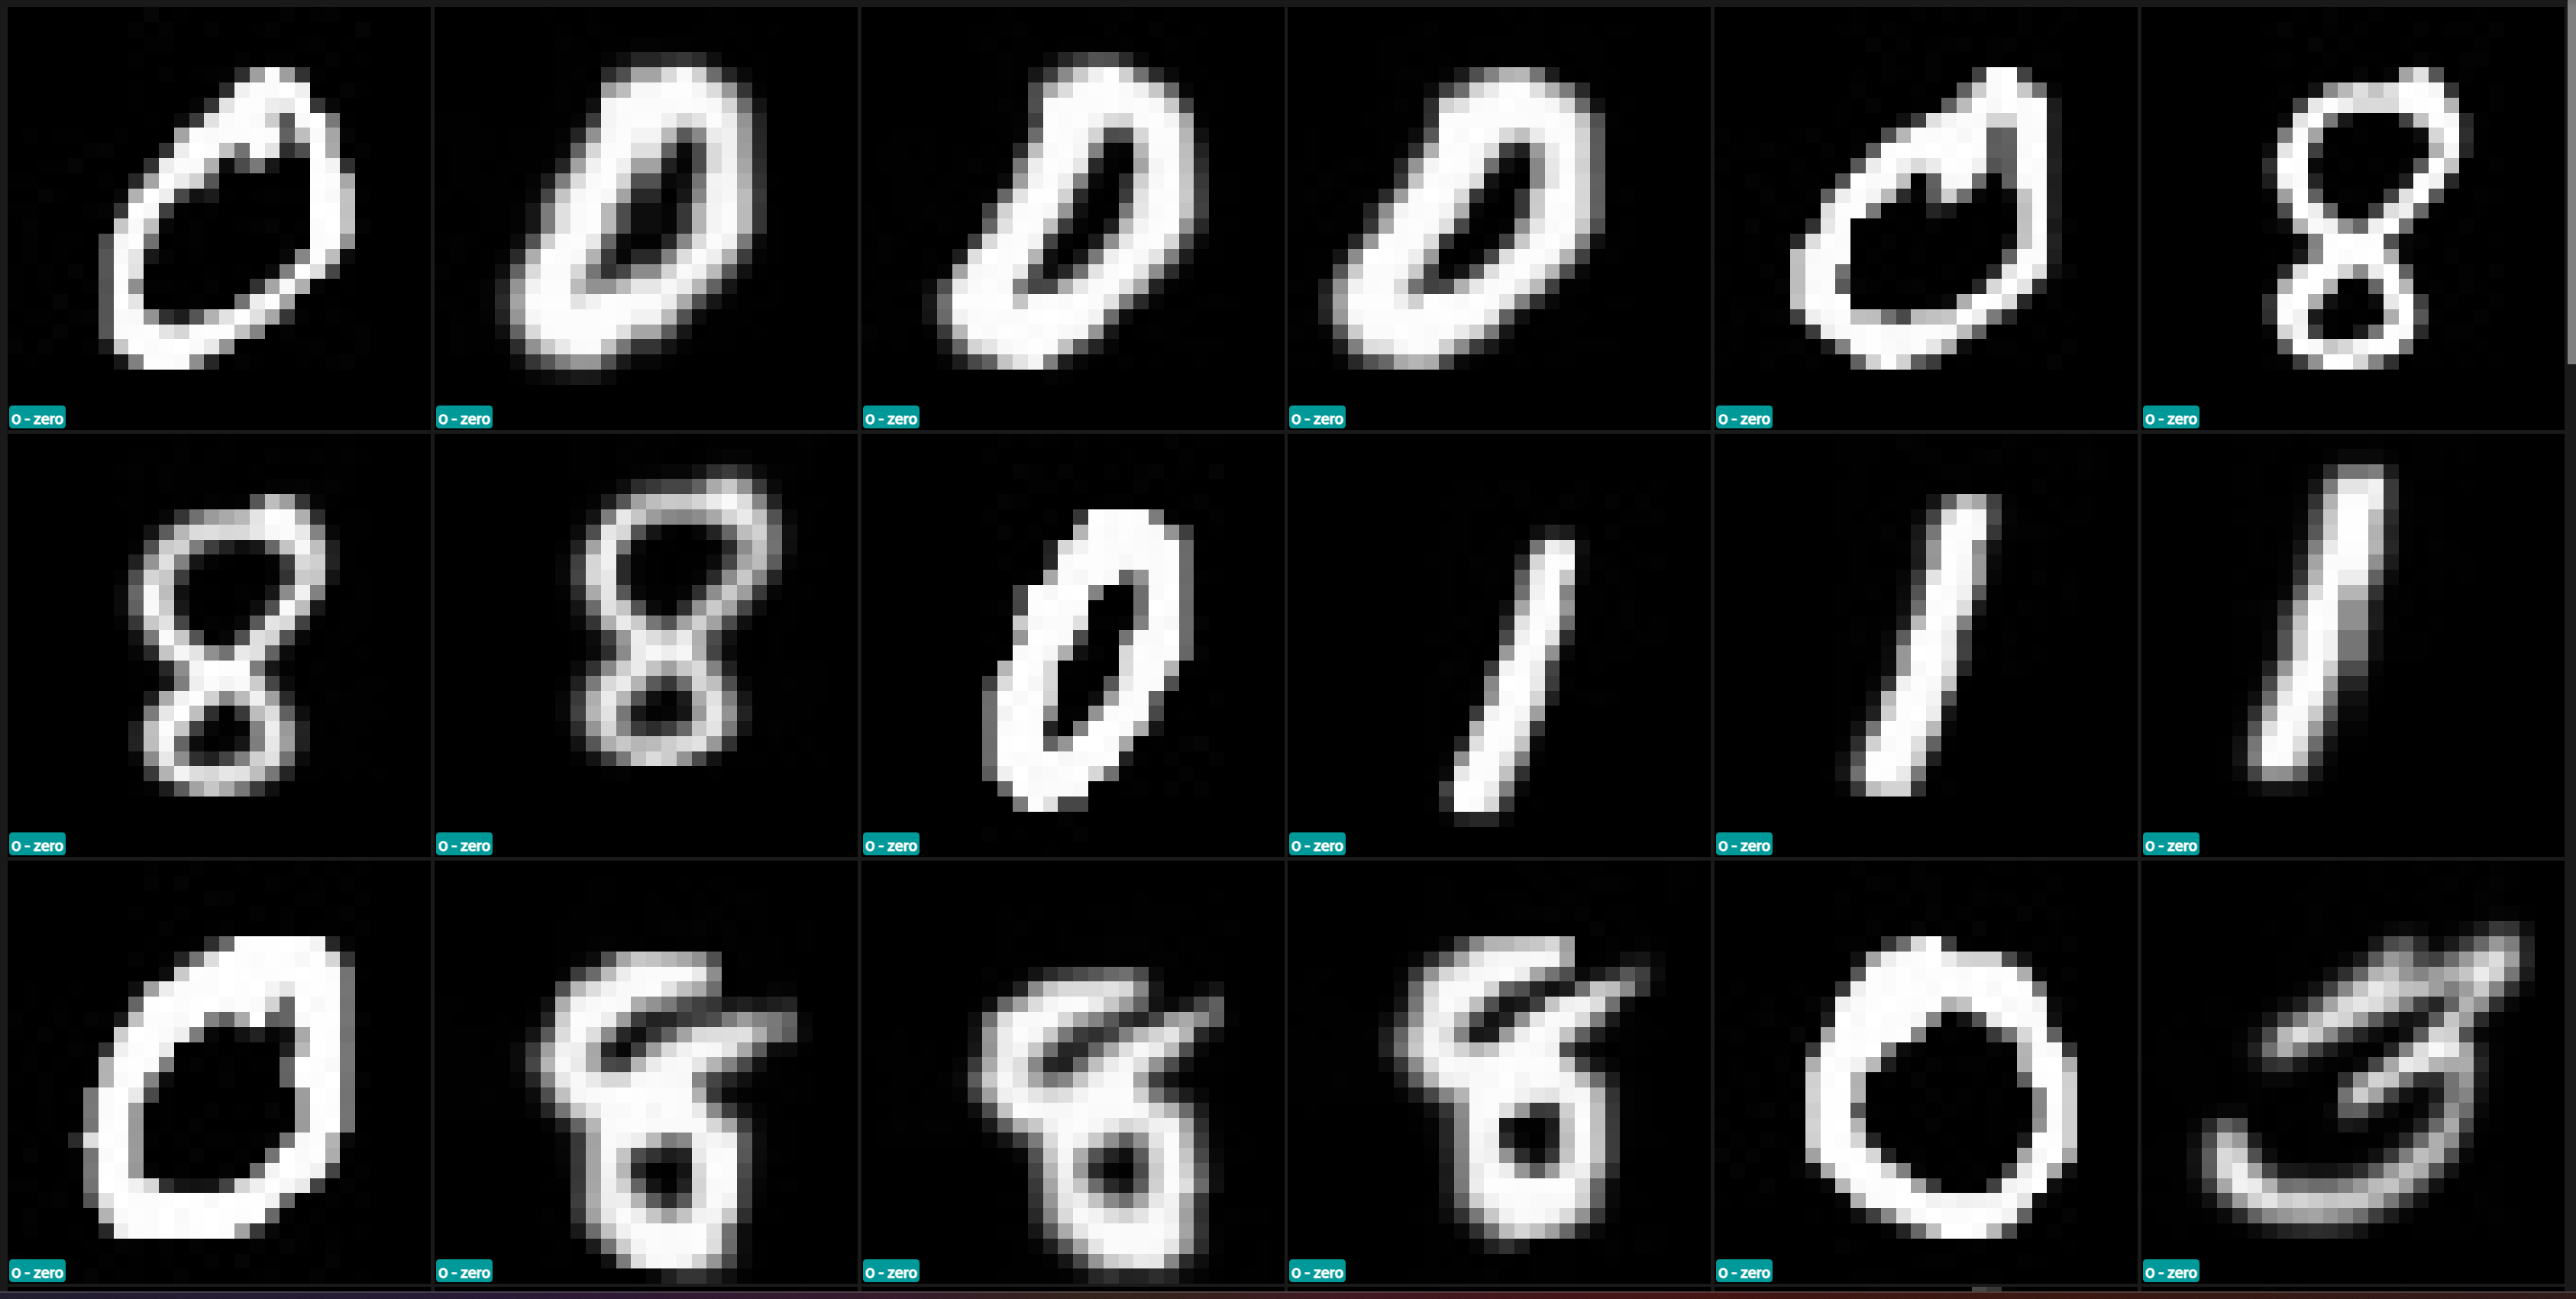

In [123]:
print("Creating idk augmentation visualization dataset...")

# Create the visualization dataset
aug_viz_dataset = create_augmentation_samples(
    train_dataset.match(F(f"ground_truth.label") == "idk"),
    mnist_augmentations,
    num_samples=100,
    dataset_name="train_idk_augmented"
)

print(f"Created visualization dataset with {len(aug_viz_dataset)} samples")
print(f"Original samples: {len(aug_viz_dataset.match_tags('original'))}")
print(f"Augmented samples: {len(aug_viz_dataset.match_tags('augmented'))}")

# Launch FiftyOne App to visualize the augmentations
session.view = aug_viz_dataset.view()

print(f"\nAugmentation Visualization URL: {session.url}")

Creating idk augmentation visualization dataset...
Created visualization dataset with 400 samples
Original samples: 100
Augmented samples: 300

Augmentation Visualization URL: https://5151-m-s-34qmbw7p4vnk8-c.us-central1-0.prod.colab.dev?polling=true


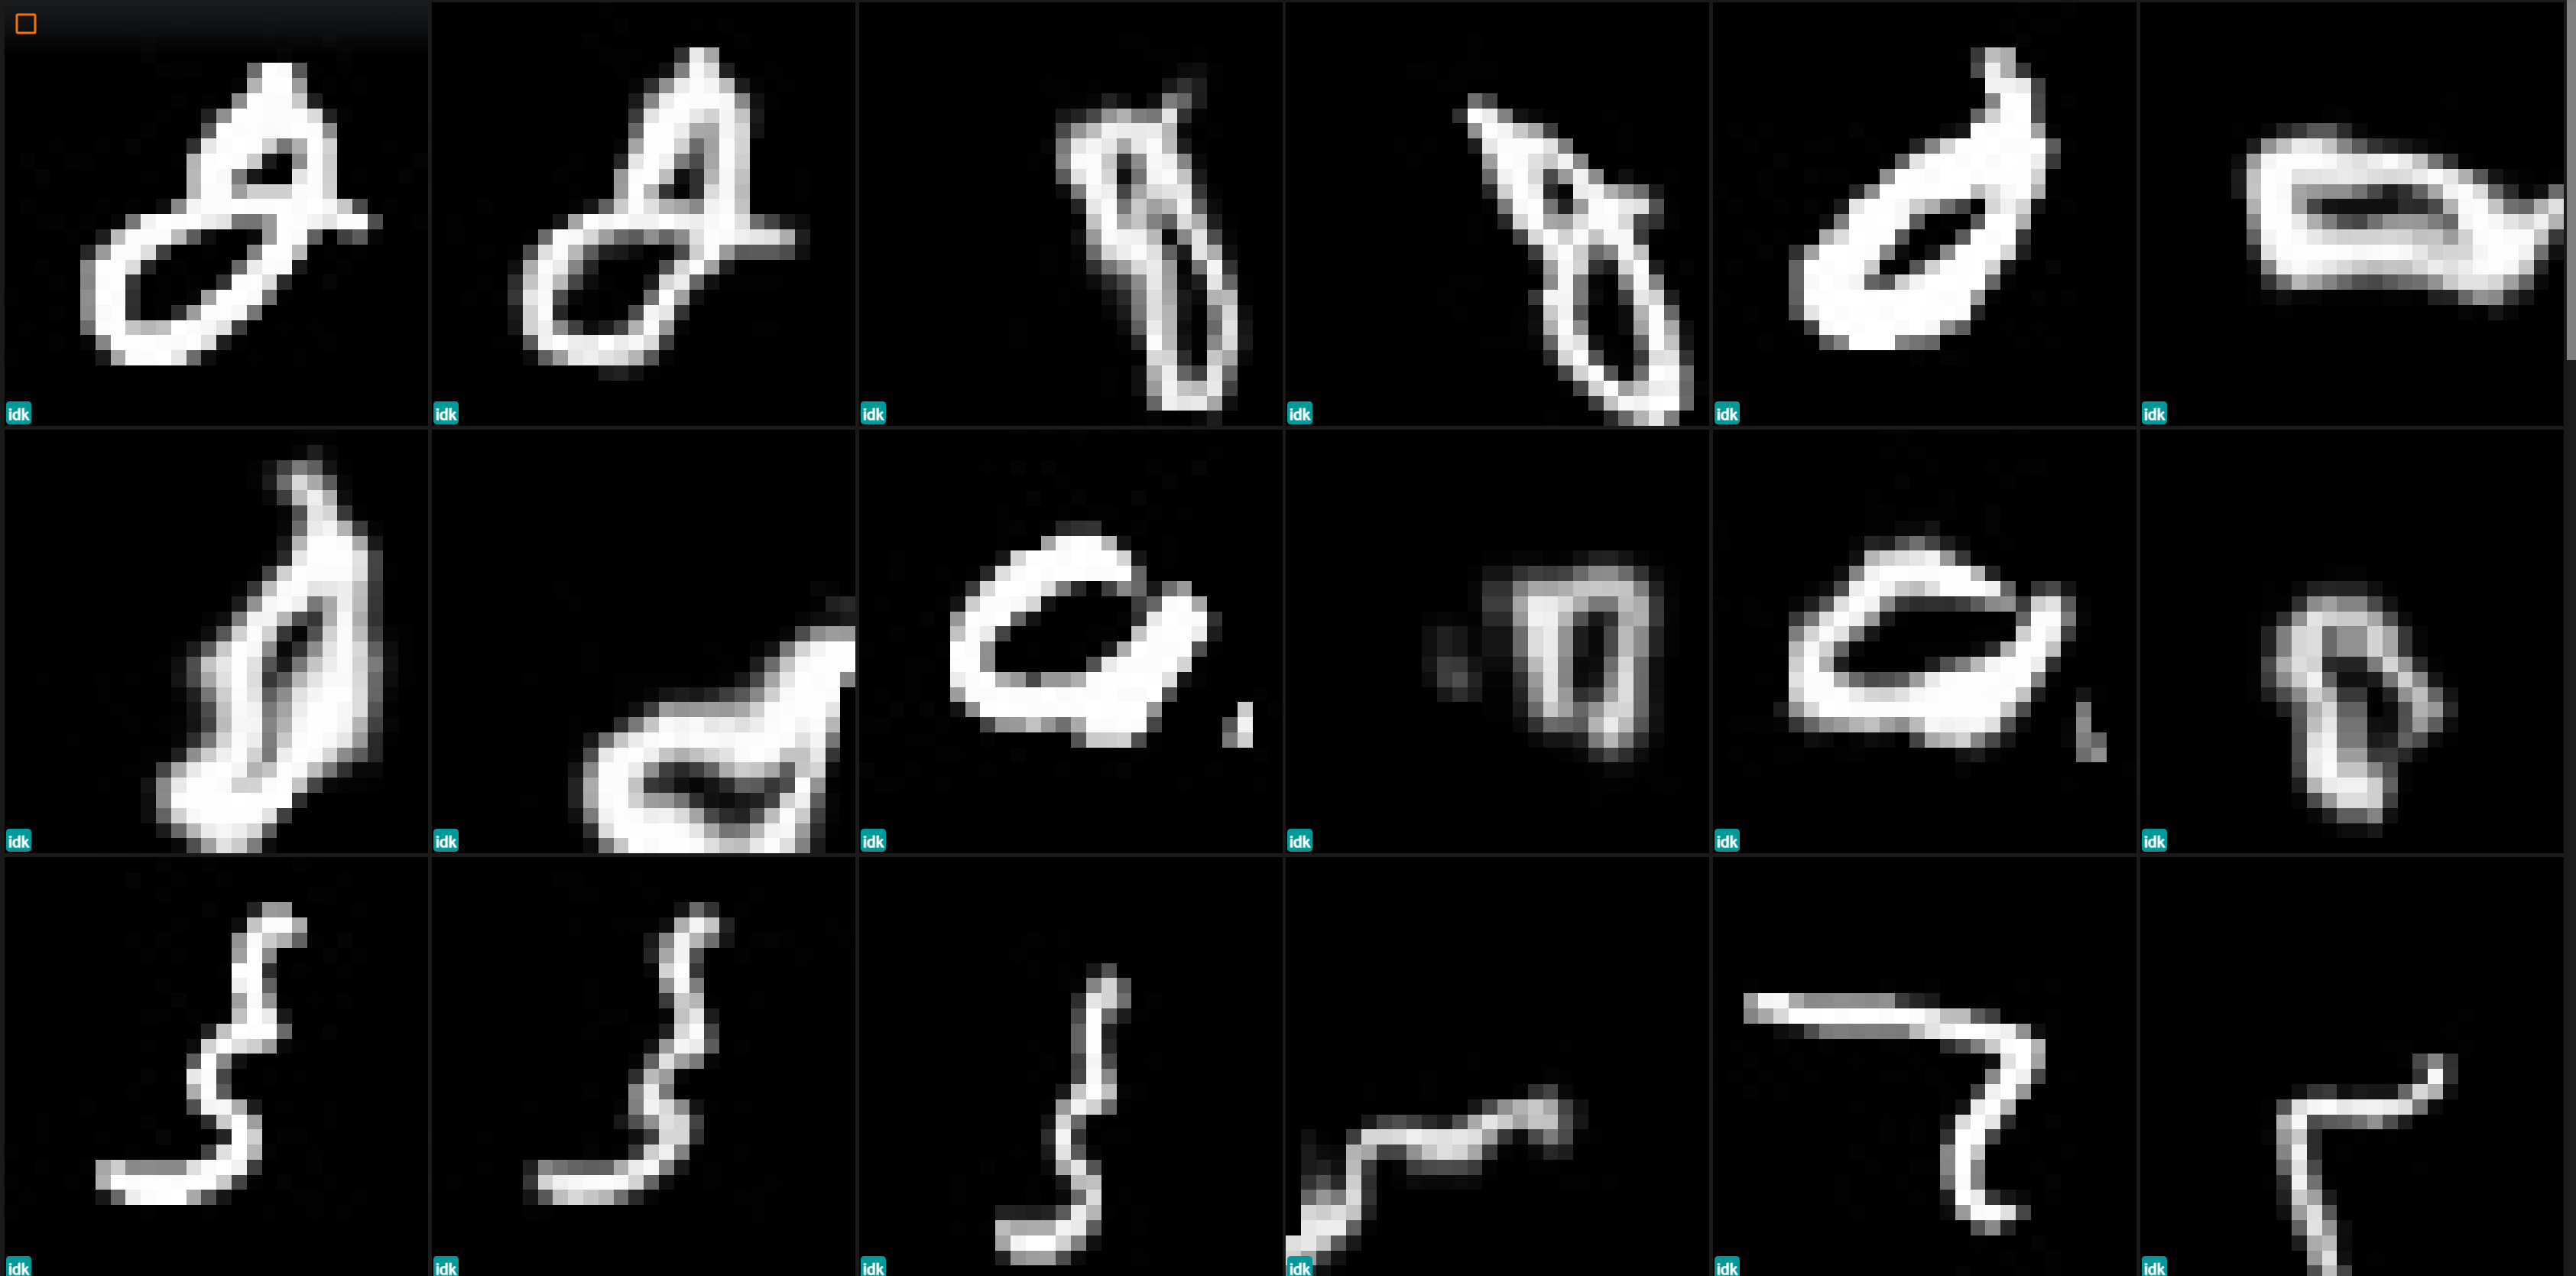

We also generate some new samples from the valid digids by deforming them.

In [85]:
idk_deformation = A.Compose([
    A.CoarseDropout(num_holes_range=(3, 7), hole_height_range=(5, 7), hole_width_range=(5, 7), p=1.0),
    A.Affine(
        translate_percent={"x": (-0.25, 0.25), "y": (-0.25, 0.25)},
        scale=(0.6, 1.4),
        rotate=(-180, 180),
        p=0.8
    ),
    A.Affine(
        translate_percent={"y": (-0.6, 0.6)},
        p=0.05
    ), # for some... move half of it out at the bottom or top
    # A.ElasticTransform(alpha=30, sigma=2.5, border_mode=cv2.BORDER_CONSTANT, p=0.8),
    # A.Perspective(scale=(0.01, 0.03), p=0.2),
])

In [66]:
from copy import deepcopy

class DeformedMNISTDataset(Dataset):
    """
    Dataset that generates 'idk' samples from normal MNIST images
    by applying strong deformations/augmentations.
    """
    def __init__(self, fiftyone_view, label_map, base_transforms,
                 deformation_augmentation):
        """
        Args:
            fiftyone_view: FiftyOne view of original MNIST images
            label_map: dict mapping string labels to integers
            base_transforms: PyTorch transforms (tensor conversion, normalization)
            deformation_augmentation: Albumentations Compose object
        """
        self.image_paths = fiftyone_view.values("filepath")
        self.num_base_samples = len(self.image_paths)
        self.label_map = label_map
        self.base_transforms = base_transforms
        self.deformation_augmentation = deformation_augmentation

    def get_int_labels(self):
        return [self.label_map["idk"]] * len(self)

    def __len__(self):
        return self.num_base_samples

    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('L')
        image_np = np.array(image, dtype=np.uint8)

        # Apply deformation
        augmented = self.deformation_augmentation(image=image_np)
        image_np = augmented['image']

        # Convert back to PIL and apply base transforms
        image = Image.fromarray(image_np).convert("L")
        if self.base_transforms:
            image = self.base_transforms(image)

        # Forced label = 'idk'
        label_idx = torch.tensor(self.label_map["idk"], dtype=torch.long)

        return image, label_idx


In [86]:
# Create a small dataset with original and deformed versions for visualization
def create_deformation_samples(view, deformation, num_samples=50):
    """Create FiftyOne samples showing original and deformed versions"""

    dataset_name = "deformed_images_training_set"

    if dataset_name in fo.list_datasets():
        def_viz_dataset = fo.load_dataset(dataset_name)
    else:
        def_viz_dataset = fo.Dataset(dataset_name)

    sample = view.take(num_samples)
    sample_paths = sample.values("filepath")
    sample_labels = sample.values("ground_truth.label")

    for i, (path, label) in enumerate(zip(sample_paths, sample_labels)):
        # Load original image
        original_image = Image.open(path).convert('L')
        original_np = np.array(original_image)

        # Create sample for original image
        original_sample = fo.Sample(filepath=path)
        original_sample.tags = ["original"]
        original_sample["ground_truth"] = fo.Classification(label=label)
        original_sample["deformation_type"] = "original"
        def_viz_dataset.add_sample(original_sample)

        # Create 3 deformed versions
        for def_idx in range(3):
            # Apply deformation
            deformed = deformation(image=original_np)['image']

            # Save deformed image temporarily
            def_image = Image.fromarray(deformed).convert("L")
            temp_path = f"/tmp/def_{i}_{def_idx}.png"
            def_image.save(temp_path)

            # Create FiftyOne sample for augmented image
            def_sample = fo.Sample(filepath=temp_path)
            def_sample.tags = ["deformed"]
            def_sample["ground_truth"] = fo.Classification(label=label)
            def_sample["deformation_type"] = f"deformed_{def_idx + 1}"
            def_sample["original_sample_id"] = str(i)

            def_viz_dataset.add_sample(def_sample)

    return def_viz_dataset

print("Creating deformation visualization dataset...")

# Create the visualization dataset
def_viz_dataset = create_deformation_samples(
    train_dataset,
    idk_deformation,
    num_samples=50
)

print(f"Created visualization dataset with {len(def_viz_dataset)} samples")
print(f"Original samples: {len(def_viz_dataset.match_tags('original'))}")
print(f"Deformed samples: {len(def_viz_dataset.match_tags('deformed'))}")

# Launch FiftyOne App to visualize the augmentations
session.view = def_viz_dataset.view()

print(f"\Deformation Visualization URL: {session.url}")

<>:65: SyntaxWarning:

invalid escape sequence '\D'

<>:65: SyntaxWarning:

invalid escape sequence '\D'

/tmp/ipython-input-1311791529.py:65: SyntaxWarning:

invalid escape sequence '\D'



Creating deformation visualization dataset...
Created visualization dataset with 1800 samples
Original samples: 450
Deformed samples: 1350
\Deformation Visualization URL: https://5151-m-s-34qmbw7p4vnk8-c.us-central1-0.prod.colab.dev?polling=true


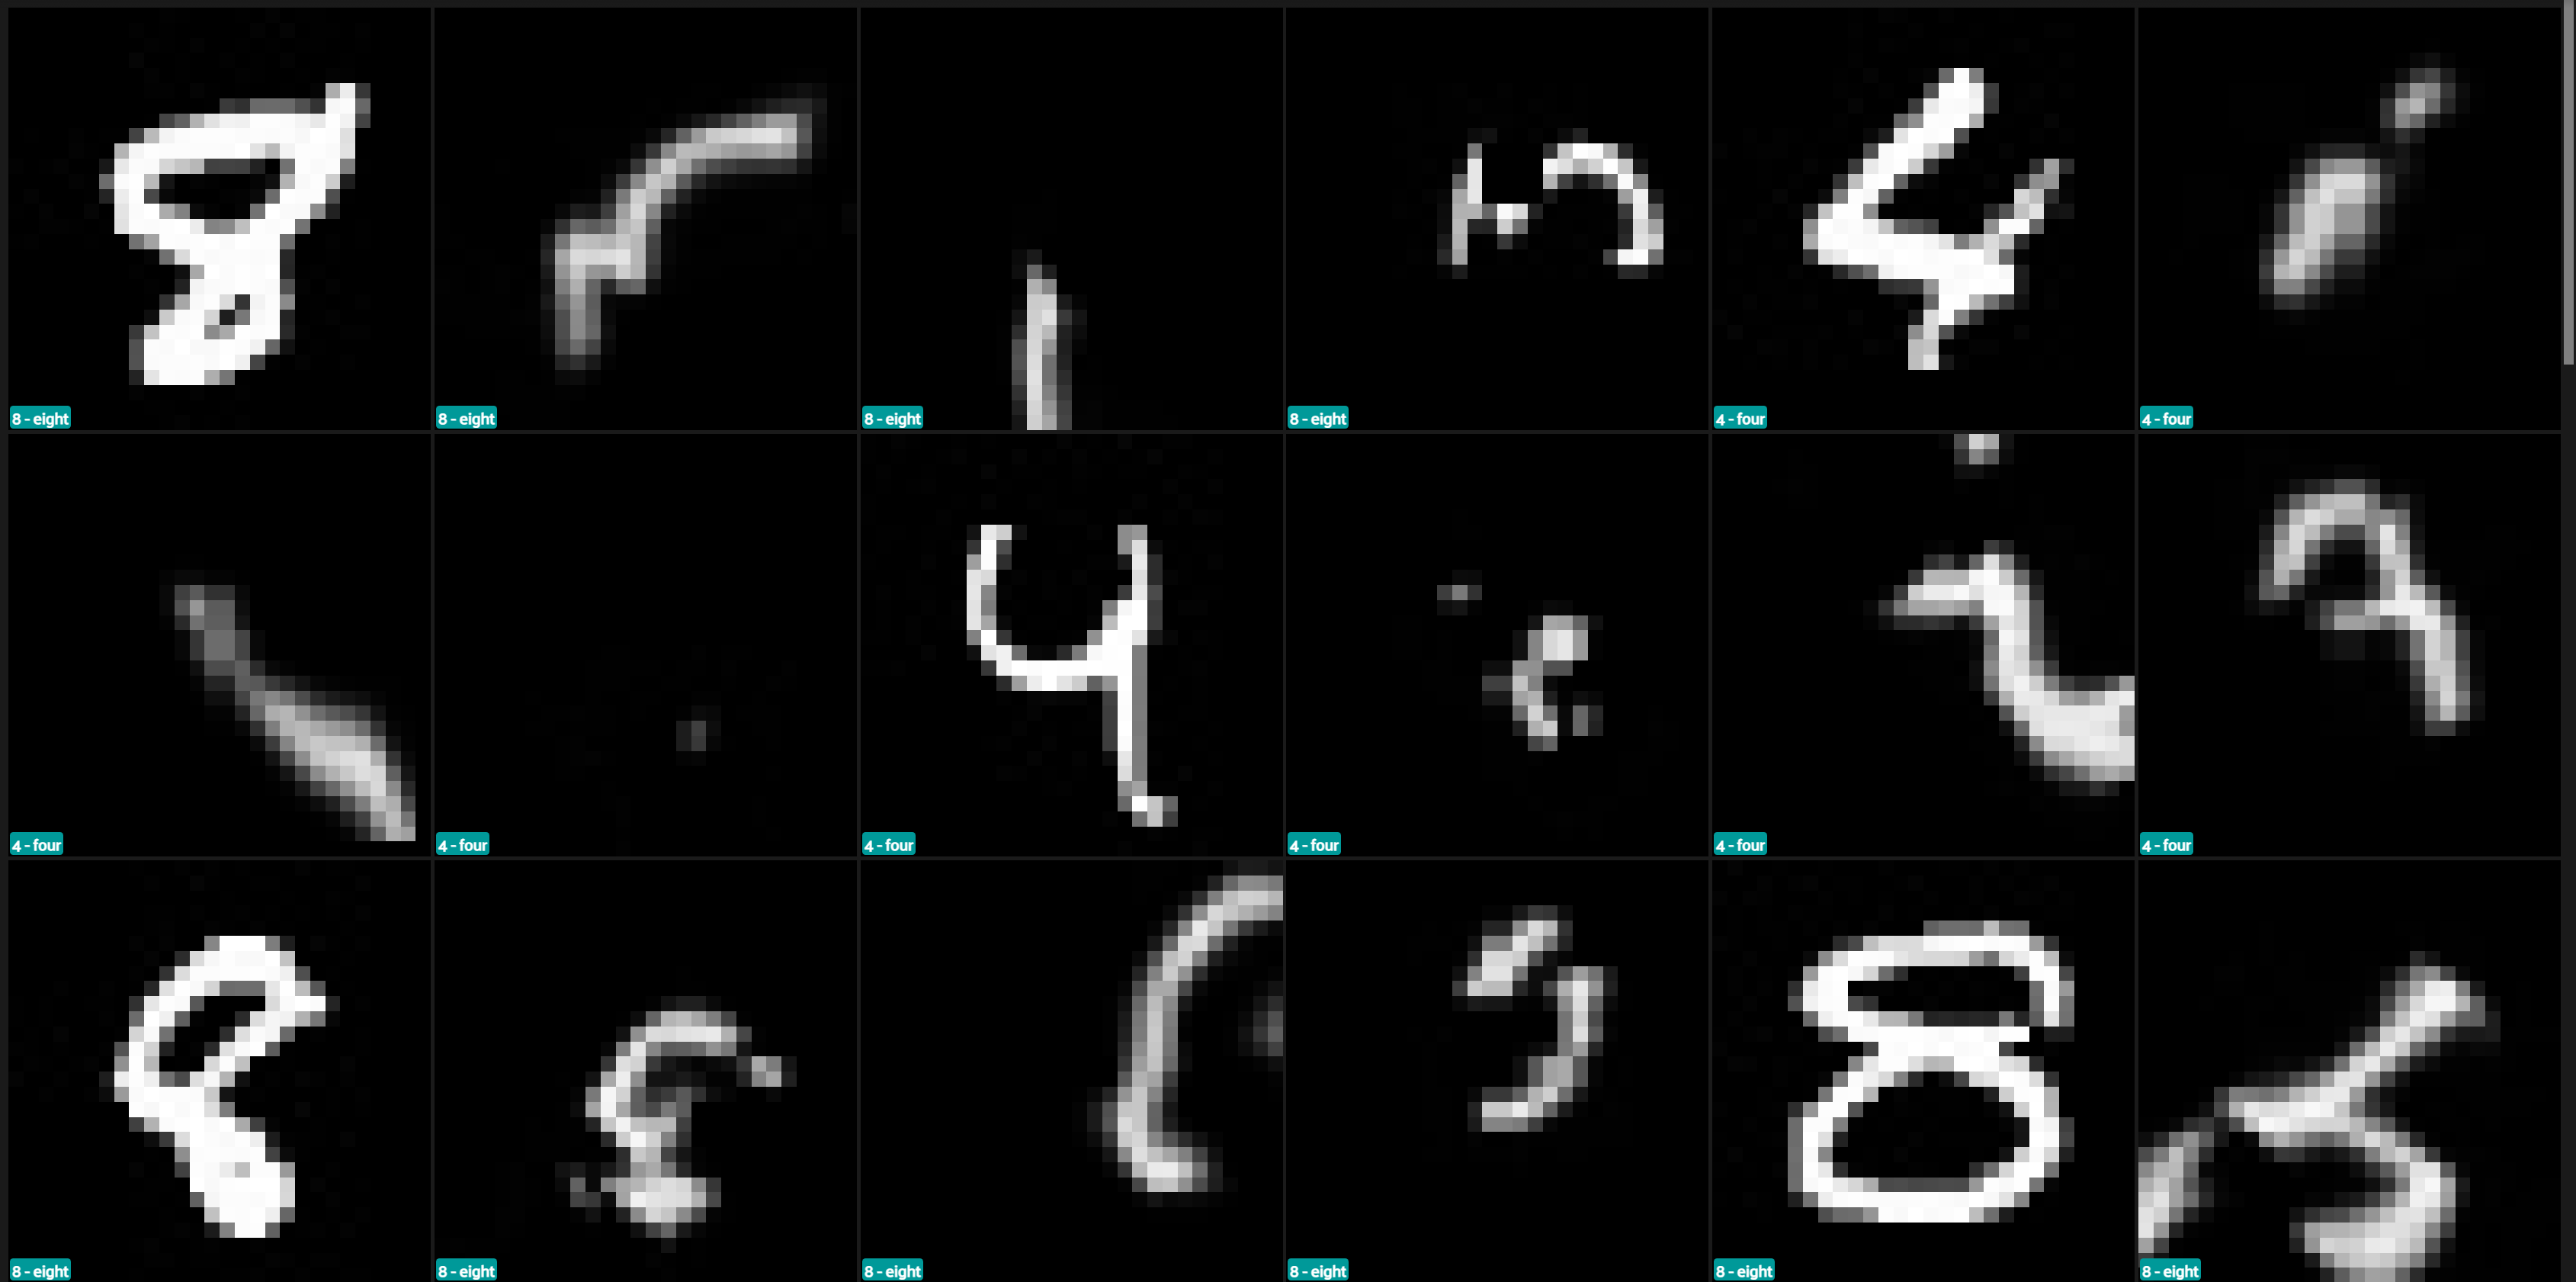

In [113]:
from PIL import Image
import random

mix_deformation = A.Compose([
    A.CoarseDropout(num_holes_range=(1, 3), hole_height_range=(5, 5), hole_width_range=(5, 5), p=0.5),
    A.Affine(
        translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
        scale=(0.9, 1.1),
        rotate=(-180, 180),
        p=0.8
    ),
    A.ElasticTransform(alpha=10, sigma=1.5, border_mode=cv2.BORDER_CONSTANT, p=0.8),
    A.Perspective(scale=(0.01, 0.03), p=0.5),
])

def mix_two_digits(img1_path, img2_path, alpha=0.5):
    """Mix two digit images by blending pixel intensities"""
    img1 = np.array(Image.open(img1_path).convert("L"), dtype=np.float32) / 255.0
    img2 = np.array(Image.open(img2_path).convert("L"), dtype=np.float32) / 255.0

    # Blend them
    mixed = (alpha * img1 + (1 - alpha) * img2)
    mixed = np.clip(mixed * 255, 0, 255).astype(np.uint8)

    mixed_pil = Image.fromarray(mixed).convert("L")
    return mixed_pil

def get_different_digit_paths(view, label):
    """Randomly pick image with *different* digit label to label"""
    i = 0
    while i < 100:
        s = view.take(1).first()
        l = s["ground_truth"].label
        if l != label:     # ensure different digits
            return s.filepath, l
        i += 1

def create_mixed_deformation_samples(view, augmentation, num_samples=50):
    dataset_name = "mixed_images_training_set"

    if dataset_name in fo.list_datasets():
        viz_ds = fo.load_dataset(dataset_name)
    else:
        viz_ds = fo.Dataset(dataset_name)

    # Sample a set of images
    sample = view.take(num_samples)

    for idx, s in enumerate(sample):
        orig_path = s.filepath
        orig_label = s.ground_truth.label

        path2, label2 = get_different_digit_paths(view, orig_label)

        mixed_img = mix_two_digits(orig_path, path2, alpha=0.5)
        # Convert to numpy for albumentations
        image_np = np.array(mixed_img, dtype=np.uint8)

        # Apply augmentation if not the first version (original)
        if augmentation is not None:
            augmented = augmentation(image=image_np)
            image_np = augmented['image']

        aug_image = Image.fromarray(image_np).convert("L")
        mixed_path = f"/tmp/mixed_idk_{idx}.png"
        aug_image.save(mixed_path)

        idk_s = fo.Sample(filepath=mixed_path)
        idk_s["ground_truth"] = fo.Classification(label="idk")
        idk_s.tags = ["idk_mixed"]
        idk_s["variant"] = "mixed_idk"
        idk_s["mixed_from"] = [orig_label, label2]

        viz_ds.add_sample(idk_s)

    return viz_ds

print("Creating deformation + mixing visualization dataset...")

viz_dataset = create_mixed_deformation_samples(
    train_dataset,
    mix_deformation,
    num_samples=50
)

print("Total samples:", len(viz_dataset))
print("Original:", len(viz_dataset.match_tags("original")))
print("Deformed:", len(viz_dataset.match_tags("deformed")))
print("Mixed IDK:", len(viz_dataset.match_tags("idk_mixed")))

session.view = viz_dataset.view()
print(session.url)

Creating deformation + mixing visualization dataset...
Total samples: 391
Original: 0
Deformed: 0
Mixed IDK: 391
https://5151-m-s-34qmbw7p4vnk8-c.us-central1-0.prod.colab.dev?polling=true


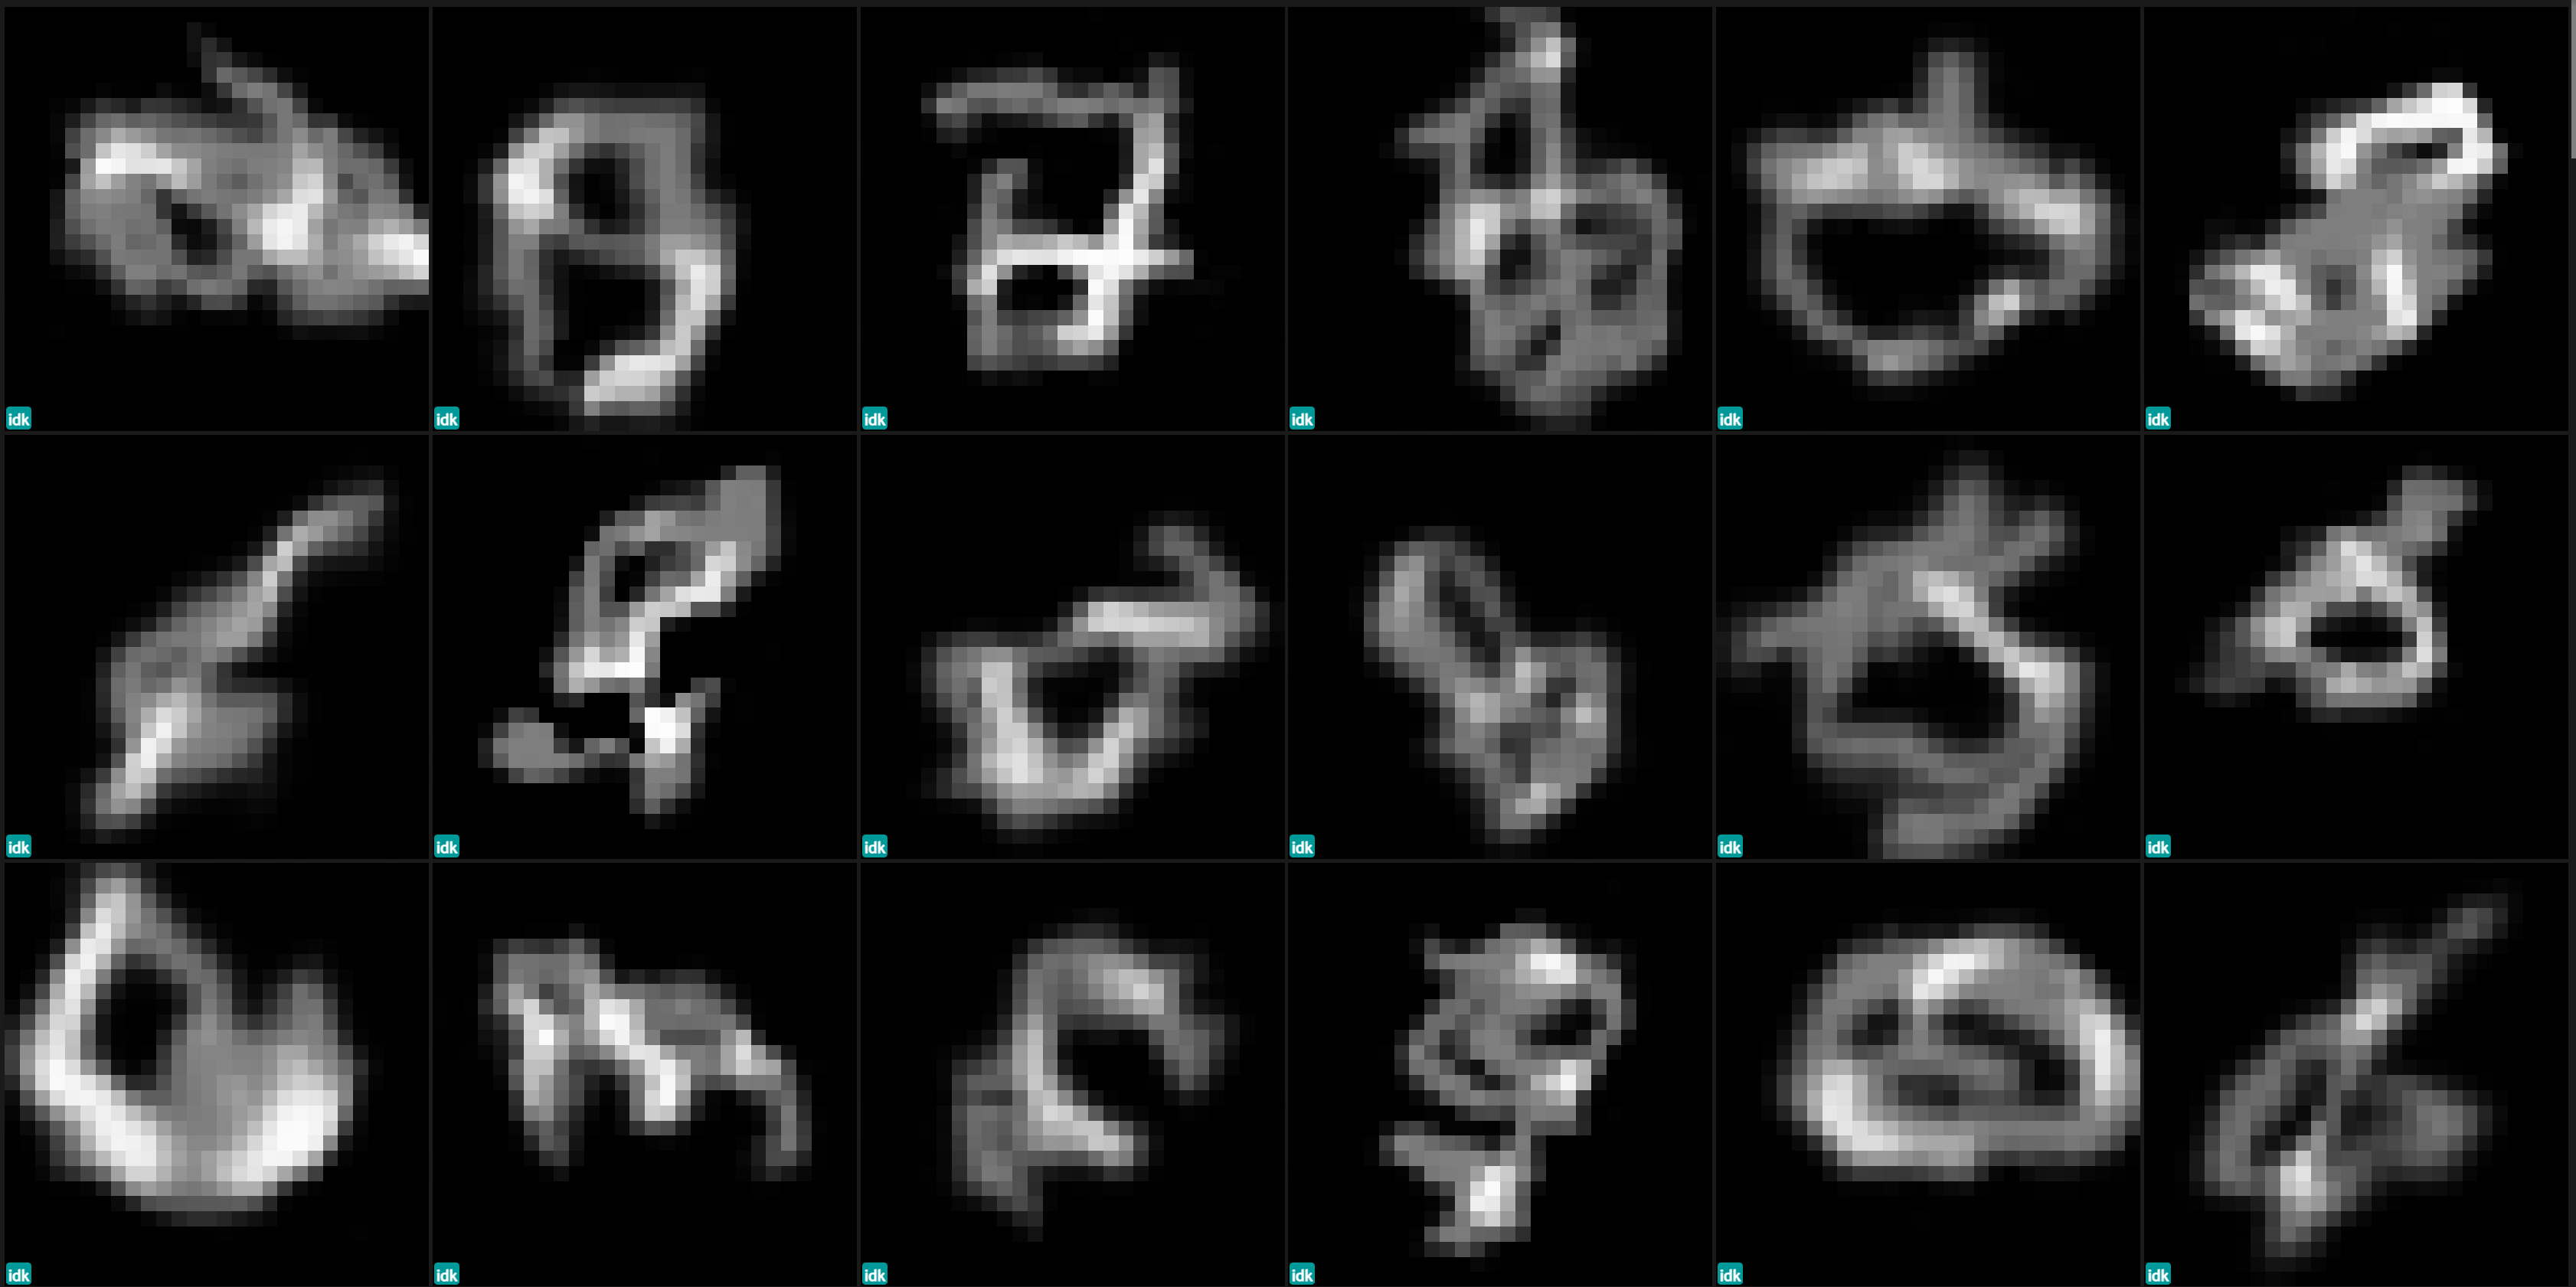

## Create the torch Dataset for the Augmented Set

**Building a Custom PyTorch Dataset for Augmented Training Data**

Creating a PyTorch Dataset for augmented data requires handling multiple variations of problematic samples while maintaining compatibility with PyTorch's DataLoader system. Our `AugmentedMNISTDataset` class applies augmentations during training, ensuring each epoch sees different variations of misclassified samples.

**Key Design Principles:**

**Dynamic Augmentation**: Apply transformations during data loading rather than pre-generating samples. This saves disk space while providing variation potential.

**Deterministic Access**: Use mathematical mapping for consistent sample ordering while allowing multiple augmented versions of each base sample. The formula `base_idx = idx // (augment_factor + 1)` determines which original sample to use.

**Integration**: Inherit from PyTorch's `Dataset` interface for compatibility with DataLoader features like batching, shuffling, and multi-process loading.

**Memory and Performance Considerations:**

**Memory Usage**: Store file paths rather than loaded images to maintain small memory footprint regardless of augmentation factor.

**Caching Strategy**: Consider implementing an LRU cache to store recent base images, reducing disk I/O during training.

**Augmentation Randomness**: Each call to `__getitem__` may produce different results due to random augmentation parameters.

**Error Resilience**: Robust error handling ensures training continues even if individual samples fail to load or augment.

This design provides a foundation for targeted data augmentation while maintaining flexibility to experiment with different augmentation strategies.

In [53]:
class AugmentedMNISTDataset(Dataset):
    """
    PyTorch dataset that applies augmentations to MNIST samples.
    Each sample can be augmented multiple times to create more training data.
    """

    def __init__(self, fiftyone_view,
                 label_map,
                 base_transforms,
                 augmentations=None,
                 augment_factor=5):
        """
        Args:
            fiftyone_view: FiftyOne view of samples to augment
            label_map: Mapping from string labels to indices
            base_transforms: Base PyTorch transforms (normalization, etc.)
            augmentations: Albumentations transform pipeline
            augment_factor: How many augmented versions to create per sample
        """
        self.image_paths = fiftyone_view.values("filepath")
        self.str_labels = fiftyone_view.values("ground_truth.label")
        self.label_map = label_map
        self.base_transforms = base_transforms
        self.augmentations = augmentations
        self.augment_factor = augment_factor

        print(f"AugmentedMNISTDataset: {len(self.image_paths)} base samples")
        print(f"With augmentation factor {augment_factor}: {len(self)} total samples")

    def get_int_labels(self):
        return [self.label_map.get(s, -1) for s in self.str_labels]

    def __len__(self):
        return len(self.image_paths) * (self.augment_factor + 1)  # +1 for original

    def __getitem__(self, idx):
        # Determine which base sample and whether to augment
        base_idx = idx // (self.augment_factor + 1)
        aug_idx = idx % (self.augment_factor + 1)

        # Get label
        label_str = self.str_labels[base_idx]
        label_idx = self.label_map.get(label_str, -1)

        # Load image
        image_path = self.image_paths[base_idx]
        image = Image.open(image_path).convert('L')

        # Convert to numpy for albumentations
        image_np = np.array(image, dtype=np.uint8)

        # Apply augmentation if not the first version (original)
        if aug_idx > 0 and self.augmentations is not None:
            augmentation = self.augmentations.get(label_str, self.augmentations["default"])
            augmented = augmentation(image=image_np)
            image_np = augmented['image']

        # Convert back to PIL for PyTorch transforms
        image = Image.fromarray(image_np).convert("L")

        # Apply base transforms (normalization, tensor conversion)
        if self.base_transforms:
            image = self.base_transforms(image)

        return image, torch.tensor(label_idx, dtype=torch.long)

In [116]:
def split_idk(dataset, label_field="ground_truth"):
    """
    Splits a FiftyOne dataset into two new datasets:
      - idk_dataset: samples where label_field.label == "idk"
      - rest_dataset: all remaining samples

    Returns: (idk_dataset, rest_dataset)
    """
    idk_name = f"{dataset.name}_idk"
    rest_name = f"{dataset.name}_rest"

    # Create fresh or load existing
    if idk_name in fo.list_datasets():
        fo.delete_dataset(idk_name)
    if rest_name in fo.list_datasets():
        fo.delete_dataset(rest_name)

    idk_dataset = fo.Dataset(idk_name)
    rest_dataset = fo.Dataset(rest_name)

    # Create views
    idk_view = dataset.match(F(f"{label_field}.label") == "idk")
    rest_view = dataset.match(F(f"{label_field}.label") != "idk")

    # Add samples
    idk_dataset.add_samples(idk_view)
    rest_dataset.add_samples(rest_view)

    return idk_dataset, rest_dataset

idk_dataset, rest_dataset = split_idk(train_dataset)
print(idk_dataset)
print(rest_dataset)

 100% |█████████████████| 208/208 [493.6ms elapsed, 0s remaining, 424.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 208/208 [493.6ms elapsed, 0s remaining, 424.6 samples/s]      


 100% |█████████████| 50792/50792 [1.2m elapsed, 0s remaining, 681.9 samples/s]      


INFO:eta.core.utils: 100% |█████████████| 50792/50792 [1.2m elapsed, 0s remaining, 681.9 samples/s]      


Name:        mnist-curated-train_idk
Media type:  image
Num samples: 208
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
Name:        mnist-curated-train_rest
Media type:  image
Num samples: 50792
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.cor

In [133]:
torch_rest_dataset = AugmentedMNISTDataset(
    rest_dataset,
    label_map=label_map,
    base_transforms=image_transforms,
    augmentations=None,
    augment_factor=0 # Create this number of augmented versions per input sample
)

print(f"Original Non-IDK Labels: {len(rest_dataset)}")
print(f'')
print(f"Total augmented dataset size: {len(torch_rest_dataset)}")

AugmentedMNISTDataset: 50792 base samples
With augmentation factor 0: 50792 total samples
Original Non-IDK Labels: 50792

Total augmented dataset size: 50792


In [129]:
torch_augmented_idk_dataset = AugmentedMNISTDataset(
    idk_dataset,
    label_map=label_map,
    base_transforms=image_transforms,
    augmentations=mnist_augmentations,
    augment_factor=10 # Create this number of augmented versions per input sample
)

print(f"Original IDK Labels: {len(idk_dataset)}")
print(f'')
print(f"Total augmented dataset size: {len(torch_augmented_idk_dataset)}")

AugmentedMNISTDataset: 208 base samples
With augmentation factor 10: 2288 total samples
Original IDK Labels: 208

Total augmented dataset size: 2288


In [55]:
class_counts # original class_counts computed above

Counter({0: 4989,
         1: 5703,
         2: 5093,
         3: 5205,
         4: 4934,
         5: 4548,
         6: 5002,
         7: 5326,
         8: 4968,
         9: 5024,
         10: 208})

In [125]:
n = 500
subset_to_deform = train_dataset.take(n, seed=99)
torch_deformed_idk_dataset = DeformedMNISTDataset(
    subset_to_deform,
    label_map=label_map,
    base_transforms=image_transforms,
    deformation_augmentation=idk_deformation,
)

torch_deformed_idk_dataset

In [126]:
n2 = 500
mixed_idk_dataset = create_mixed_deformation_samples(
    train_dataset,
    mix_deformation,
    num_samples=n2,
)

torch_mixed_idk_dataset = AugmentedMNISTDataset(
    mixed_idk_dataset,
    label_map=label_map,
    base_transforms=image_transforms,
    augmentations=None,
    augment_factor=0 # Create this number of augmented versions per input sample
)

torch_mixed_idk_dataset

AugmentedMNISTDataset: 1287 base samples
With augmentation factor 0: 1287 total samples


In [134]:
# Combine the original dataset with its augmentation
combined_dataset = ConcatDataset([torch_rest_dataset, torch_augmented_idk_dataset, torch_deformed_idk_dataset, torch_mixed_idk_dataset])
print(f"Combined dataset size: {len(combined_dataset)}")

Combined dataset size: 54867


In [136]:
combined_int_labels = torch_rest_dataset.get_int_labels() + [label_map.get("idk", -1)] * (len(torch_augmented_idk_dataset) + len(torch_deformed_idk_dataset) + len(torch_mixed_idk_dataset))
# Count samples per class
combined_class_counts = Counter(combined_int_labels)
print(combined_class_counts)

Counter({1: 5703, 7: 5326, 3: 5205, 2: 5093, 9: 5024, 6: 5002, 0: 4989, 8: 4968, 4: 4934, 5: 4548, 10: 4075})


In [138]:
# Weight for each class = 1 / num_samples_in_class
combined_class_weights = {cls: 1.0 / count for cls, count in combined_class_counts.items()}

# Assign weight to each sample
combined_sample_weights = [class_weights[label] for label in combined_int_labels]
combined_sample_weights = torch.DoubleTensor(sample_weights)
combined_class_weights

{0: 0.00020044097013429546,
 1: 0.0001753463089601964,
 2: 0.00019634792852935403,
 3: 0.00019212295869356388,
 4: 0.00020267531414673692,
 5: 0.00021987686895338611,
 6: 0.00019992003198720512,
 7: 0.0001877581674802854,
 8: 0.00020128824476650564,
 9: 0.00019904458598726116,
 10: 0.000245398773006135}

In [139]:
from torch.utils.data import WeightedRandomSampler

combined_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [140]:
# Create new DataLoader for combined dataset
combined_train_loader = create_deterministic_training_dataloader(
    combined_dataset,
    batch_size=64,
    sampler=combined_sampler,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)


print(f"Combined DataLoader has {len(combined_train_loader)} batches.")


Combined DataLoader has 797 batches.


## Fine-Tuning with Augmented Data

In [142]:
## Load Best Model for Retraining

# Ensure reproducibility for the retraining process
set_seeds(51) # Use the same seed as initial training for consistency

# Load the previously saved best model
best_model_path = Path(os.getcwd()) / 'best_lenet.pth'
retrain_model = ModernLeNet5(num_classes=len(label_map))
retrain_model.load_state_dict(torch.load(best_model_path, map_location=device))
retrain_model = retrain_model.to(device)

print(f"Loaded best model from {best_model_path} for retraining")

# Use a lower learning rate for fine-tuning
retrain_optimizer = Adam(retrain_model.parameters(), lr=0.0001,
                       weight_decay=1e-3)
# 10x stronger regularization
# 30x smaller learning rate

print("\nStarting retraining with augmented data...")

retrain_epochs = 15
retrain_losses = []
retrain_val_losses = []

# Track the best validation loss during retraining
best_retrain_val_loss = float('inf')
retrain_model_save_path = Path(os.getcwd()) / 'retrained_lenet.pth'

for epoch in range(retrain_epochs):
    print(f"\n--- Retrain Epoch {epoch+1}/{retrain_epochs} ---")

    # Training phase
    retrain_model.train()
    batch_losses = []

    for images, labels in tqdm(combined_train_loader, desc="Retraining"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = retrain_model(images)
        loss_value = ce_loss(logits, labels)

        # Backward pass
        retrain_optimizer.zero_grad()
        loss_value.backward()
        retrain_optimizer.step()

        batch_losses.append(loss_value.item())

    train_loss = np.mean(batch_losses)
    retrain_losses.append(train_loss)

    # Validation phase
    retrain_model.eval()
    val_batch_losses = []

    with torch.inference_mode():
        for images, labels in tqdm(val_loader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device)

            logits = retrain_model(images)
            loss_value = ce_loss(logits, labels)
            val_batch_losses.append(loss_value.item())

    val_loss = np.mean(val_batch_losses)
    retrain_val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save best model during retraining
    if val_loss < best_retrain_val_loss:
        best_retrain_val_loss = val_loss
        torch.save(retrain_model.state_dict(), retrain_model_save_path)
        print("✓ Saved improved retrained model")

print(f"\nRetraining complete! Best model saved to {retrain_model_save_path}")




All random seeds set to 51 for reproducibility
Loaded best model from /content/best_lenet.pth for retraining

Starting retraining with augmented data...

--- Retrain Epoch 1/15 ---


Validation: 100%|██████████| 141/141 [00:05<00:00, 26.66it/s]


Epoch 1: Train Loss: 0.1934, Val Loss: 0.1179
✓ Saved improved retrained model

--- Retrain Epoch 2/15 ---


Validation: 100%|██████████| 141/141 [00:10<00:00, 13.79it/s]


Epoch 2: Train Loss: 0.1159, Val Loss: 0.1110
✓ Saved improved retrained model

--- Retrain Epoch 3/15 ---


Validation: 100%|██████████| 141/141 [00:04<00:00, 28.78it/s]


Epoch 3: Train Loss: 0.0968, Val Loss: 0.1007
✓ Saved improved retrained model

--- Retrain Epoch 4/15 ---


Validation: 100%|██████████| 141/141 [00:04<00:00, 28.47it/s]


Epoch 4: Train Loss: 0.0792, Val Loss: 0.0994
✓ Saved improved retrained model

--- Retrain Epoch 5/15 ---


Validation: 100%|██████████| 141/141 [00:06<00:00, 23.48it/s]


Epoch 5: Train Loss: 0.0683, Val Loss: 0.0926
✓ Saved improved retrained model

--- Retrain Epoch 6/15 ---


Validation: 100%|██████████| 141/141 [00:04<00:00, 28.38it/s]


Epoch 6: Train Loss: 0.0601, Val Loss: 0.0885
✓ Saved improved retrained model

--- Retrain Epoch 7/15 ---


Validation: 100%|██████████| 141/141 [00:07<00:00, 18.13it/s]


Epoch 7: Train Loss: 0.0568, Val Loss: 0.0869
✓ Saved improved retrained model

--- Retrain Epoch 8/15 ---


Validation: 100%|██████████| 141/141 [00:04<00:00, 29.08it/s]


Epoch 8: Train Loss: 0.0520, Val Loss: 0.0870

--- Retrain Epoch 9/15 ---


Validation: 100%|██████████| 141/141 [00:07<00:00, 18.68it/s]


Epoch 9: Train Loss: 0.0495, Val Loss: 0.0793
✓ Saved improved retrained model

--- Retrain Epoch 10/15 ---


Validation: 100%|██████████| 141/141 [00:04<00:00, 29.35it/s]


Epoch 10: Train Loss: 0.0452, Val Loss: 0.0786
✓ Saved improved retrained model

--- Retrain Epoch 11/15 ---


Validation: 100%|██████████| 141/141 [00:07<00:00, 18.42it/s]


Epoch 11: Train Loss: 0.0428, Val Loss: 0.0796

--- Retrain Epoch 12/15 ---


Validation: 100%|██████████| 141/141 [00:04<00:00, 28.78it/s]


Epoch 12: Train Loss: 0.0403, Val Loss: 0.0850

--- Retrain Epoch 13/15 ---


Validation: 100%|██████████| 141/141 [00:07<00:00, 18.76it/s]


Epoch 13: Train Loss: 0.0356, Val Loss: 0.0826

--- Retrain Epoch 14/15 ---


Validation: 100%|██████████| 141/141 [00:04<00:00, 29.49it/s]


Epoch 14: Train Loss: 0.0356, Val Loss: 0.0790

--- Retrain Epoch 15/15 ---


Validation: 100%|██████████| 141/141 [00:05<00:00, 23.96it/s]

Epoch 15: Train Loss: 0.0369, Val Loss: 0.0767
✓ Saved improved retrained model

Retraining complete! Best model saved to /content/retrained_lenet.pth


## Plot Re-Training Progress

**Visualizing Training Dynamics Across Phases**

Training visualization reveals model learning patterns during both initial training and retraining with augmented data. Loss curves show convergence behavior, overfitting signals, and the impact of targeted data augmentation.

**Two-Panel Analysis**

The left panel shows retraining progress in isolation, tracking how the model adapts to augmented misclassified training samples.

The right panel provides historical context by plotting the complete training timeline. The vertical line marks where retraining begins, allowing comparison between original learning dynamics and fine-tuning behavior.

**Key Patterns to Observe**

- **Convergence Speed**: Retraining typically converges faster than initial training due to pre-learned features
- **Loss Magnitude**: Validation loss during retraining should remain close to or below original best values  
- **Stability**: Smooth loss curves indicate stable learning, while oscillations suggest learning rate issues
- **Gap Analysis**: Small train-validation gaps indicate good generalization

**Interpreting Results**

Successful retraining shows decreasing validation loss without diverging from training loss. If validation loss increases while training loss decreases, we have trained the model enough. We will be using the state of the model that achieved the lowest validation loss.


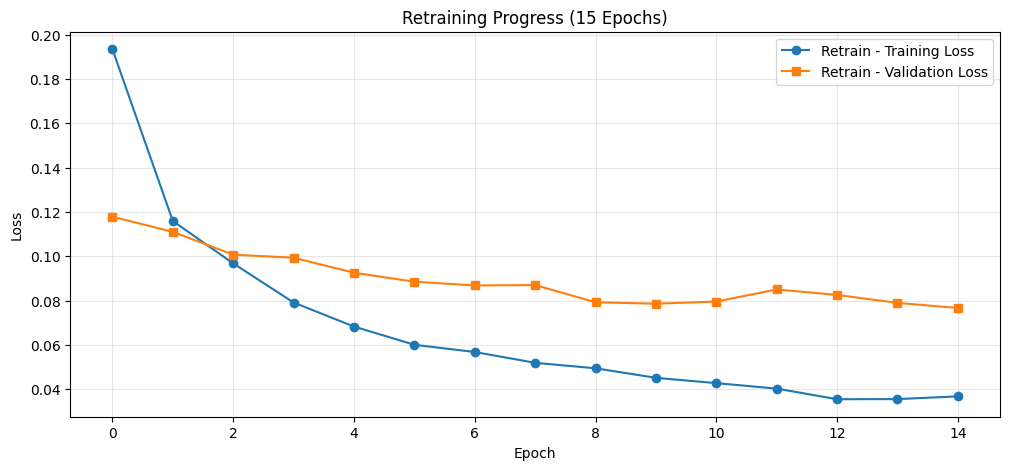

In [146]:
plt.figure(figsize=(12, 5))

# Plot retraining losses
plt.plot(retrain_losses, label='Retrain - Training Loss', marker='o')
plt.plot(retrain_val_losses, label='Retrain - Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Retraining Progress ({retrain_epochs} Epochs)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

## Applying the Fine-tuned Model to the Test Set

Following is a brief description of what we are doing in this section.

**Evaluating Augmented Model Performance**

* Load the best retrained model weights and apply to the test dataset.

* Generate predictions and logits for performance comparison against the original model.

**Model Loading Process**

* Instantiate a fresh model architecture and load the saved state dictionary from retraining.

* Move to the GPU (if available) and set evaluation mode for inference without gradient computation.

**Inference Pipeline**

* Process test images through the fine-tuned model using the same preprocessing pipeline as training.

* Extract both predicted class indices and raw logits for comprehensive evaluation.

**Result Storage**

Collect predictions and logits in arrays for analysis. This enables comparison between original model performance and improvements from targeted data augmentation on challenging samples.

In [147]:
print("\nApplying retrained model to test set...")

# Load the best retrained model
final_model = ModernLeNet5(num_classes=len(label_map))
final_model.load_state_dict(torch.load(retrain_model_save_path, map_location=device))
final_model = final_model.to(device)
final_model.eval()

# Apply retrained model to test set
retrained_predictions = []
retrained_logits = []

with torch.inference_mode():
    for images, _ in tqdm(test_loader, desc="Evaluating retrained model"):
        images = images.to(device)

        logits = final_model(images)
        retrained_logits.append(logits.cpu().numpy())

        _, predicted = torch.max(logits.data, 1)
        retrained_predictions.extend(predicted.cpu().numpy())

# Concatenate all results
retrained_logits = np.concatenate(retrained_logits, axis=0)

print(f"Retrained model evaluation complete.")
print(f"Predictions shape: {len(retrained_predictions)}")
print(f"Logits shape: {retrained_logits.shape}")




Applying retrained model to test set...


Evaluating retrained model: 100%|██████████| 157/157 [00:10<00:00, 14.37it/s]

Retrained model evaluation complete.
Predictions shape: 10000
Logits shape: (10000, 11)


## Store Retrained Model Predictions in FiftyOne

Here's what we are doing next:

**Integrating Fine-tuned Model Results**

* Store retrained model predictions as [FiftyOne Classification](https://docs.voxel51.com/api/fiftyone.core.labels.html#fiftyone.core.labels.Classification) objects in the test dataset.

* Each sample receives prediction label, confidence score, and raw logits for comprehensive analysis.

**Classification Object Creation**

Convert raw model outputs into structured FiftyOne format. Apply softmax to logits for confidence scores and map predicted indices to class labels using the established label mapping.

**Dataset Integration**

Add retrained predictions as a new field alongside existing CLIP and the original LeNet predictions. This enables direct comparison between all model variants within the same dataset framework.

**Analysis Preparation**

Structured storage enables filtering, querying, and evaluation using FiftyOne's built-in tools.

* [FiftyOne's Views Cheat Sheet](https://docs.voxel51.com/cheat_sheets/views_cheat_sheet.html)
* [FiftyOne's Filtering Cheat Sheet](https://docs.voxel51.com/cheat_sheets/filtering_cheat_sheet.html)

With this we compare model performance and identify samples where fine-tuning improved or degraded predictions.

In [148]:
print("Storing fine-tuned model predictions in FiftyOne...")

for i, sample in enumerate(tqdm(test_dataset, desc="Storing retrained predictions")):
    predicted_idx = retrained_predictions[i]
    predicted_label = dataset_classes[predicted_idx]
    sample_logits = retrained_logits[i]

    confidences = Fun.softmax(torch.tensor(sample_logits), dim=0).numpy()
    predicted_confidence = float(confidences[predicted_idx])

    classification = fo.Classification(
        label=predicted_label,
        confidence=predicted_confidence,
        logits=sample_logits.tolist()
    )

    sample["retrained_lenet_classification"] = classification
    sample.save()

print("Retrained model predictions stored successfully!")



Storing fine-tuned model predictions in FiftyOne...


Storing retrained predictions: 100%|██████████| 10000/10000 [00:28<00:00, 355.68it/s]

Retrained model predictions stored successfully!


## Evaluate Retrained Model Performance

**Comprehensive Assessment of Fine-tuned Model**

Evaluate the retrained model using FiftyOne's classification evaluation framework. Generate detailed performance metrics including accuracy, precision, recall, and F1-scores for direct comparison with the original model.





**Performance Comparison Analysis**

Compare original LeNet performance against the retrained model across key metrics. Calculate improvement deltas to quantify the impact of targeted data augmentation on model robustness.

In [151]:
print("\nEvaluating retrained model performance...")

# Evaluate retrained model
retrained_evaluation_results = test_dataset.evaluate_classifications(
    "retrained_lenet_classification",
    gt_field="ground_truth",
    eval_key="retrained_lenet_eval"
)

print("\n" + "="*60)
print("RETRAINED MODEL EVALUATION RESULTS")
print("="*60)
retrained_evaluation_results.print_report(digits=4)


print("\n" + "="*60)
print("ORIGINAL MODEL EVALUATION RESULTS")
print("="*60)
lenet_evaluation_results.print_report(digits=4)




Evaluating retrained model performance...

RETRAINED MODEL EVALUATION RESULTS
              precision    recall  f1-score   support

    0 - zero     0.9948    0.9816    0.9881       976
     1 - one     0.9929    0.9902    0.9916      1128
     2 - two     0.9883    0.9892    0.9888      1022
   3 - three     0.9880    0.9890    0.9885      1002
    4 - four     0.9817    0.9897    0.9857       974
    5 - five     0.9864    0.9876    0.9870       884
     6 - six     0.9883    0.9768    0.9825       949
   7 - seven     0.9823    0.9842    0.9832      1013
   8 - eight     0.9917    0.9835    0.9876       972
    9 - nine     0.9839    0.9800    0.9820      1000
         idk     0.1981    0.2625    0.2258        80

    accuracy                         0.9795     10000
   macro avg     0.9160    0.9195    0.9173     10000
weighted avg     0.9816    0.9795    0.9805     10000


ORIGINAL MODEL EVALUATION RESULTS
              precision    recall  f1-score   support

    0 - zero     0

In [157]:
retrained_evaluation_results.plot_confusion_matrix()

/usr/local/lib/python3.12/dist-packages/fiftyone/core/plots/plotly.py:1591: UserWarning:

Interactive plots are currently only supported in Jupyter notebooks. Support outside of notebooks and in Google Colab and Databricks will be included in an upcoming release. In the meantime, you can still use this plot, but note that (i) selecting data will not trigger callbacks, and (ii) you must manually call `plot.show()` to launch a new plot that reflects the current state of an attached session.

See https://docs.voxel51.com/user_guide/plots.html#working-in-notebooks for more information.



## Compare Original vs Retrained Performance


Now that we have applied both the original and retrained LeNet models to the test set, we can compare their performance side-by-side. This comparison will highlight the impact of our targeted data augmentation strategy on the model's ability to generalize to unseen data.

In [152]:
print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)

# Get metrics for both models
original_metrics = lenet_evaluation_results.metrics()
retrained_metrics = retrained_evaluation_results.metrics()

print(f"{'Metric':<20} {'Original':<12} {'Retrained':<12} {'Improvement':<12}")
print("-" * 56)

metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1']

for metric in metrics_to_compare:
    if metric in original_metrics and metric in retrained_metrics:
        orig_val = original_metrics[metric]
        retrain_val = retrained_metrics[metric]
        improvement = retrain_val - orig_val

        print(f"{metric:<20} {orig_val:<12.4f} {retrain_val:<12.4f} {improvement:+.4f}")




PERFORMANCE COMPARISON
Metric               Original     Retrained    Improvement 
--------------------------------------------------------
accuracy             0.9789       0.9795       +0.0006
precision            0.9789       0.9795       +0.0006
recall               0.9789       0.9795       +0.0006


## Analysis of Misclassified Samples After Retraining


**Misclassification Analysis**

* Identify samples fixed by retraining versus those newly misclassified.

* Compute net improvement in correct predictions to assess overall effectiveness of the augmentation strategy.

In [153]:
# Find samples that were misclassified before but correct now
originally_wrong = test_dataset.match(
    F("lenet_classification.label") != F("ground_truth.label")
)

now_correct = originally_wrong.match(
    F("retrained_lenet_classification.label") == F("ground_truth.label")
)

print(f"\nSamples fixed by retraining: {len(now_correct)}")

# Find samples that were correct before but wrong now
originally_correct = test_dataset.match(
    F("lenet_classification.label") == F("ground_truth.label")
)

now_wrong = originally_correct.match(
    F("retrained_lenet_classification.label") != F("ground_truth.label")
)

print(f"Samples broken by retraining: {len(now_wrong)}")

# Net improvement
net_improvement = len(now_correct) - len(now_wrong)
print(f"Net improvement in correct predictions: {net_improvement}")




Samples fixed by retraining: 78
Samples broken by retraining: 72
Net improvement in correct predictions: 6


## Launch FiftyOne App for Insights on the  Results


* Launch FiftyOne App with comparative views showing all model predictions. Enable exploration of specific cases where fine-tuning improved or degraded performance for model debugging.

* Create filtered view containing ground truth labels and predictions from both original and retrained models. This enables direct comparison between model variants within the same interface.

* Access interactive confusion matrices, per-class metrics, and sample-level analysis through FiftyOne's evaluation framework. Filter by prediction differences to identify which samples benefited from augmentation.

* Use FiftyOne's query language to create views of samples fixed by retraining, samples broken by retraining, or samples where both models agree or disagree with ground truth labels.

In [154]:
print("\nLaunching FiftyOne App to explore results...")

# Create a view showing the comparison
comparison_view = test_dataset.select_fields([
    "ground_truth",
    "lenet_classification",
    "retrained_lenet_classification"
])

session.view = comparison_view
session.refresh()
print(f"FiftyOne App URL: {session.url}")


Launching FiftyOne App to explore results...
FiftyOne App URL: https://5151-m-s-34qmbw7p4vnk8-c.us-central1-0.prod.colab.dev?polling=true


In [155]:
# View the samples that are fixed by fine-tuning
session.view = now_correct
session.refresh()
print(session.url)

https://5151-m-s-34qmbw7p4vnk8-c.us-central1-0.prod.colab.dev?polling=true


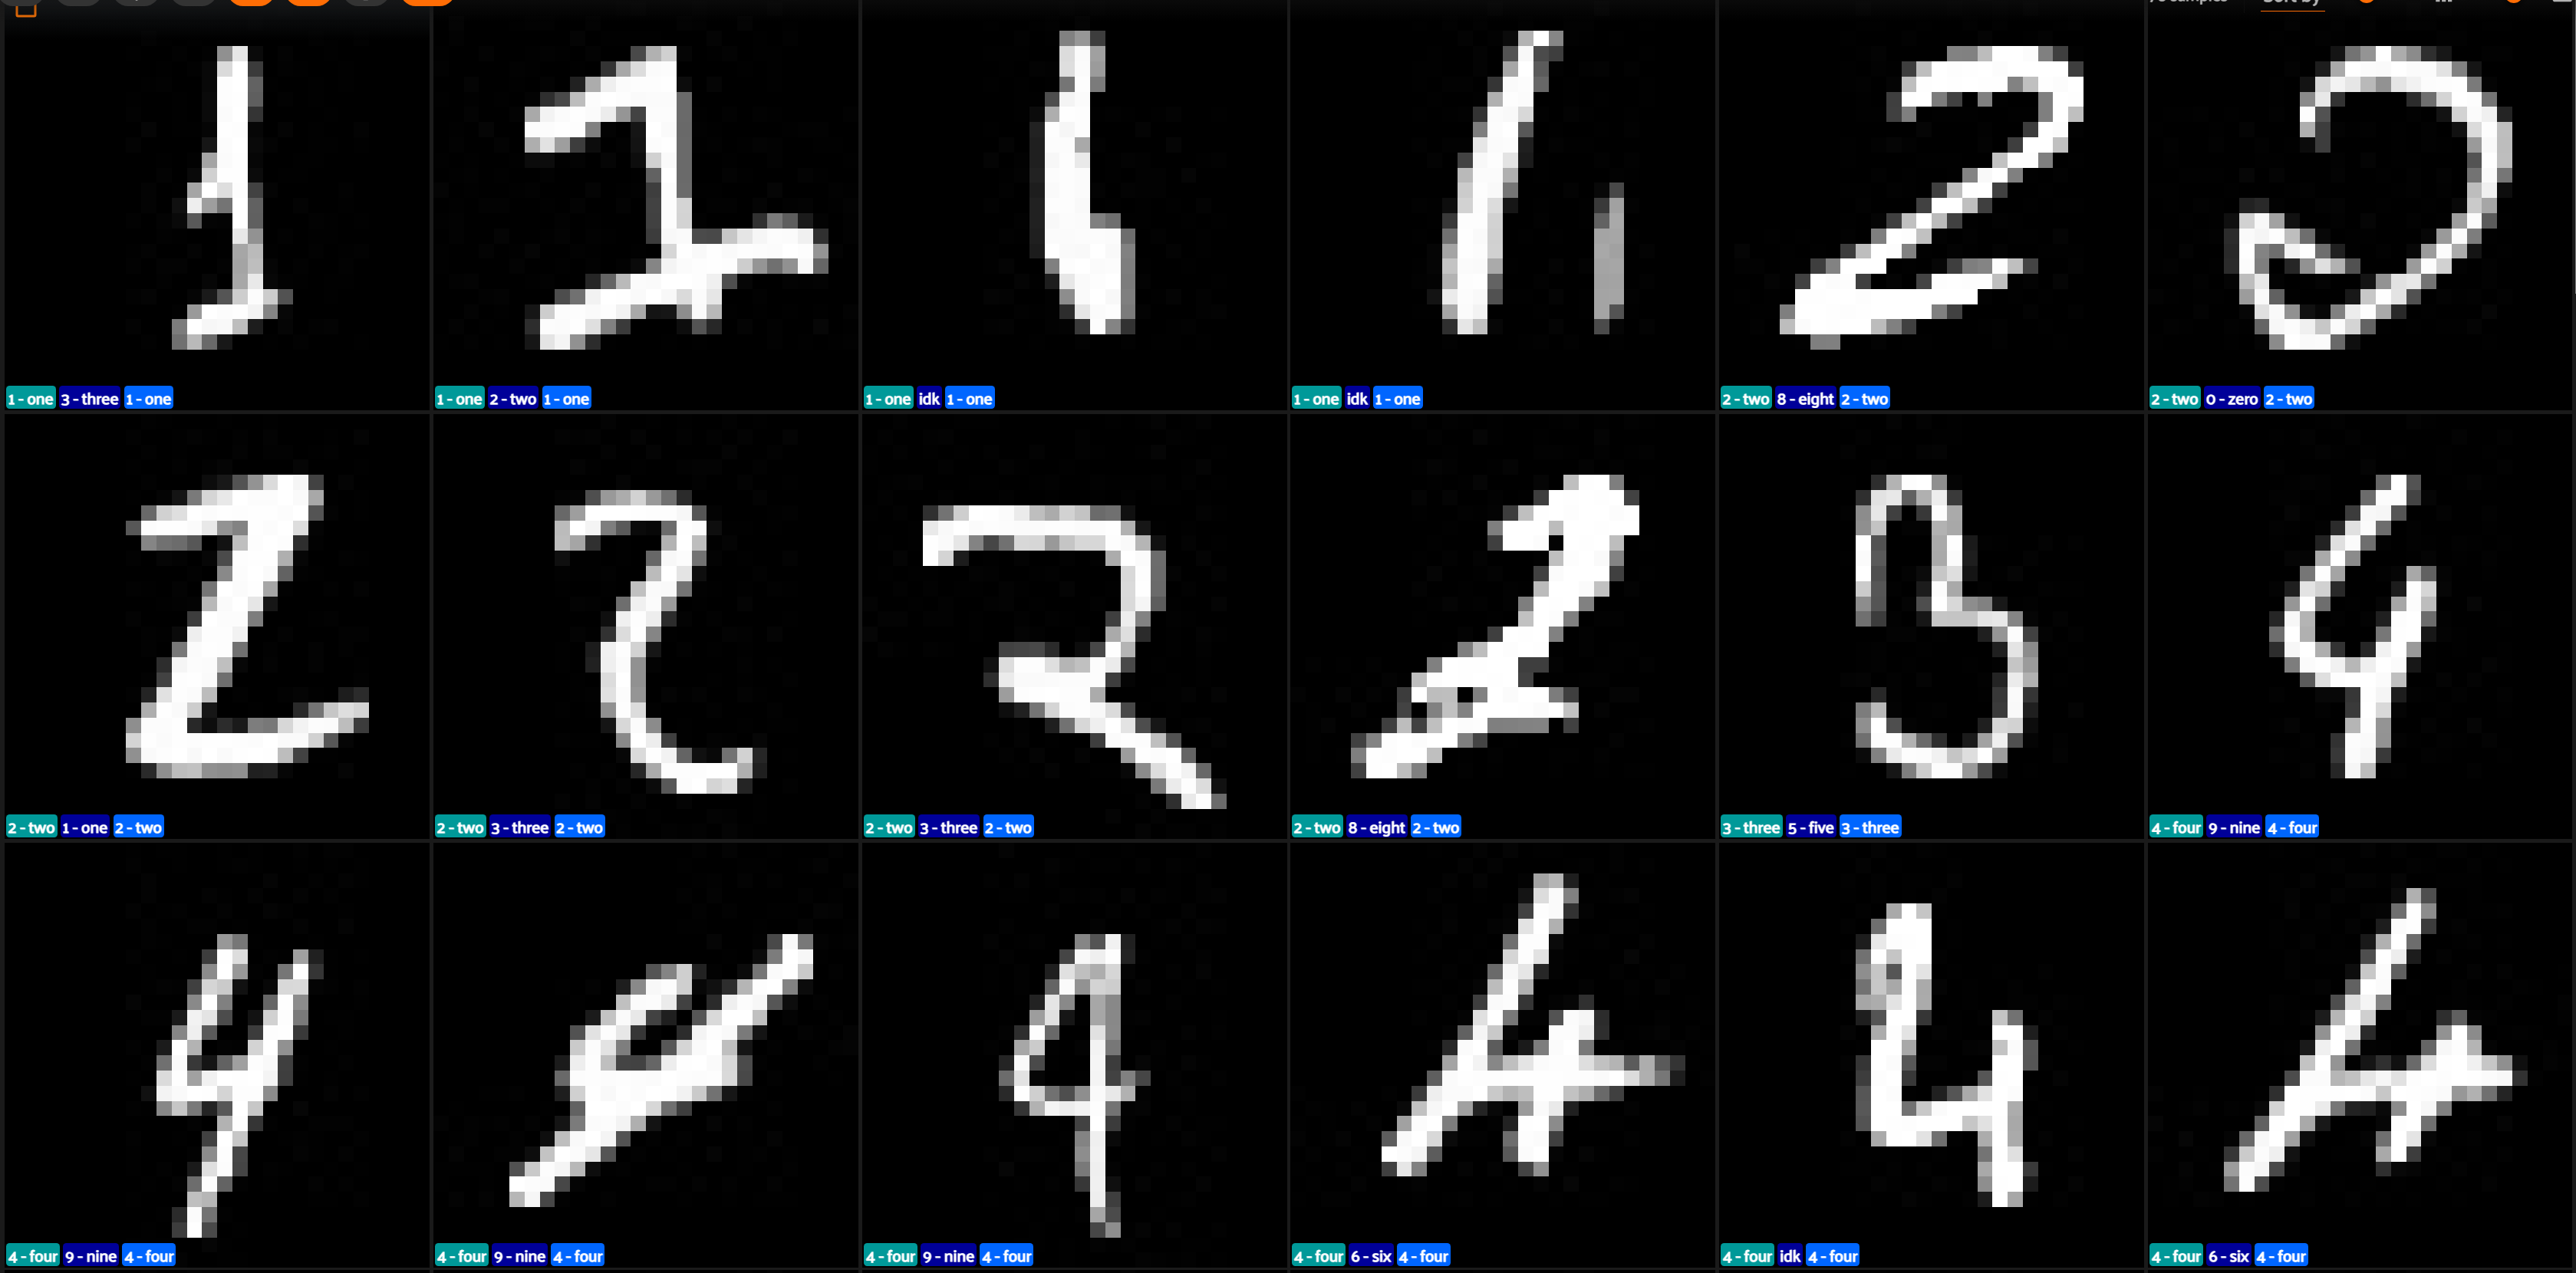

These fixed samples actually look like they were wrong before. The model clearly improved here.

In [156]:
# View the samples that are fixed by fine-tuning
session.view = now_wrong
session.refresh()
print(session.url)

https://5151-m-s-34qmbw7p4vnk8-c.us-central1-0.prod.colab.dev?polling=true


Interestingly, many 0s that are not super clean are now misclassified, often as "idk". For some of those numbers it is totally fair to classify it as "idk" since most are not very clean. I would say this model is calibrated quite well. Through active learning we can definitly clean more of MNIST dataset:

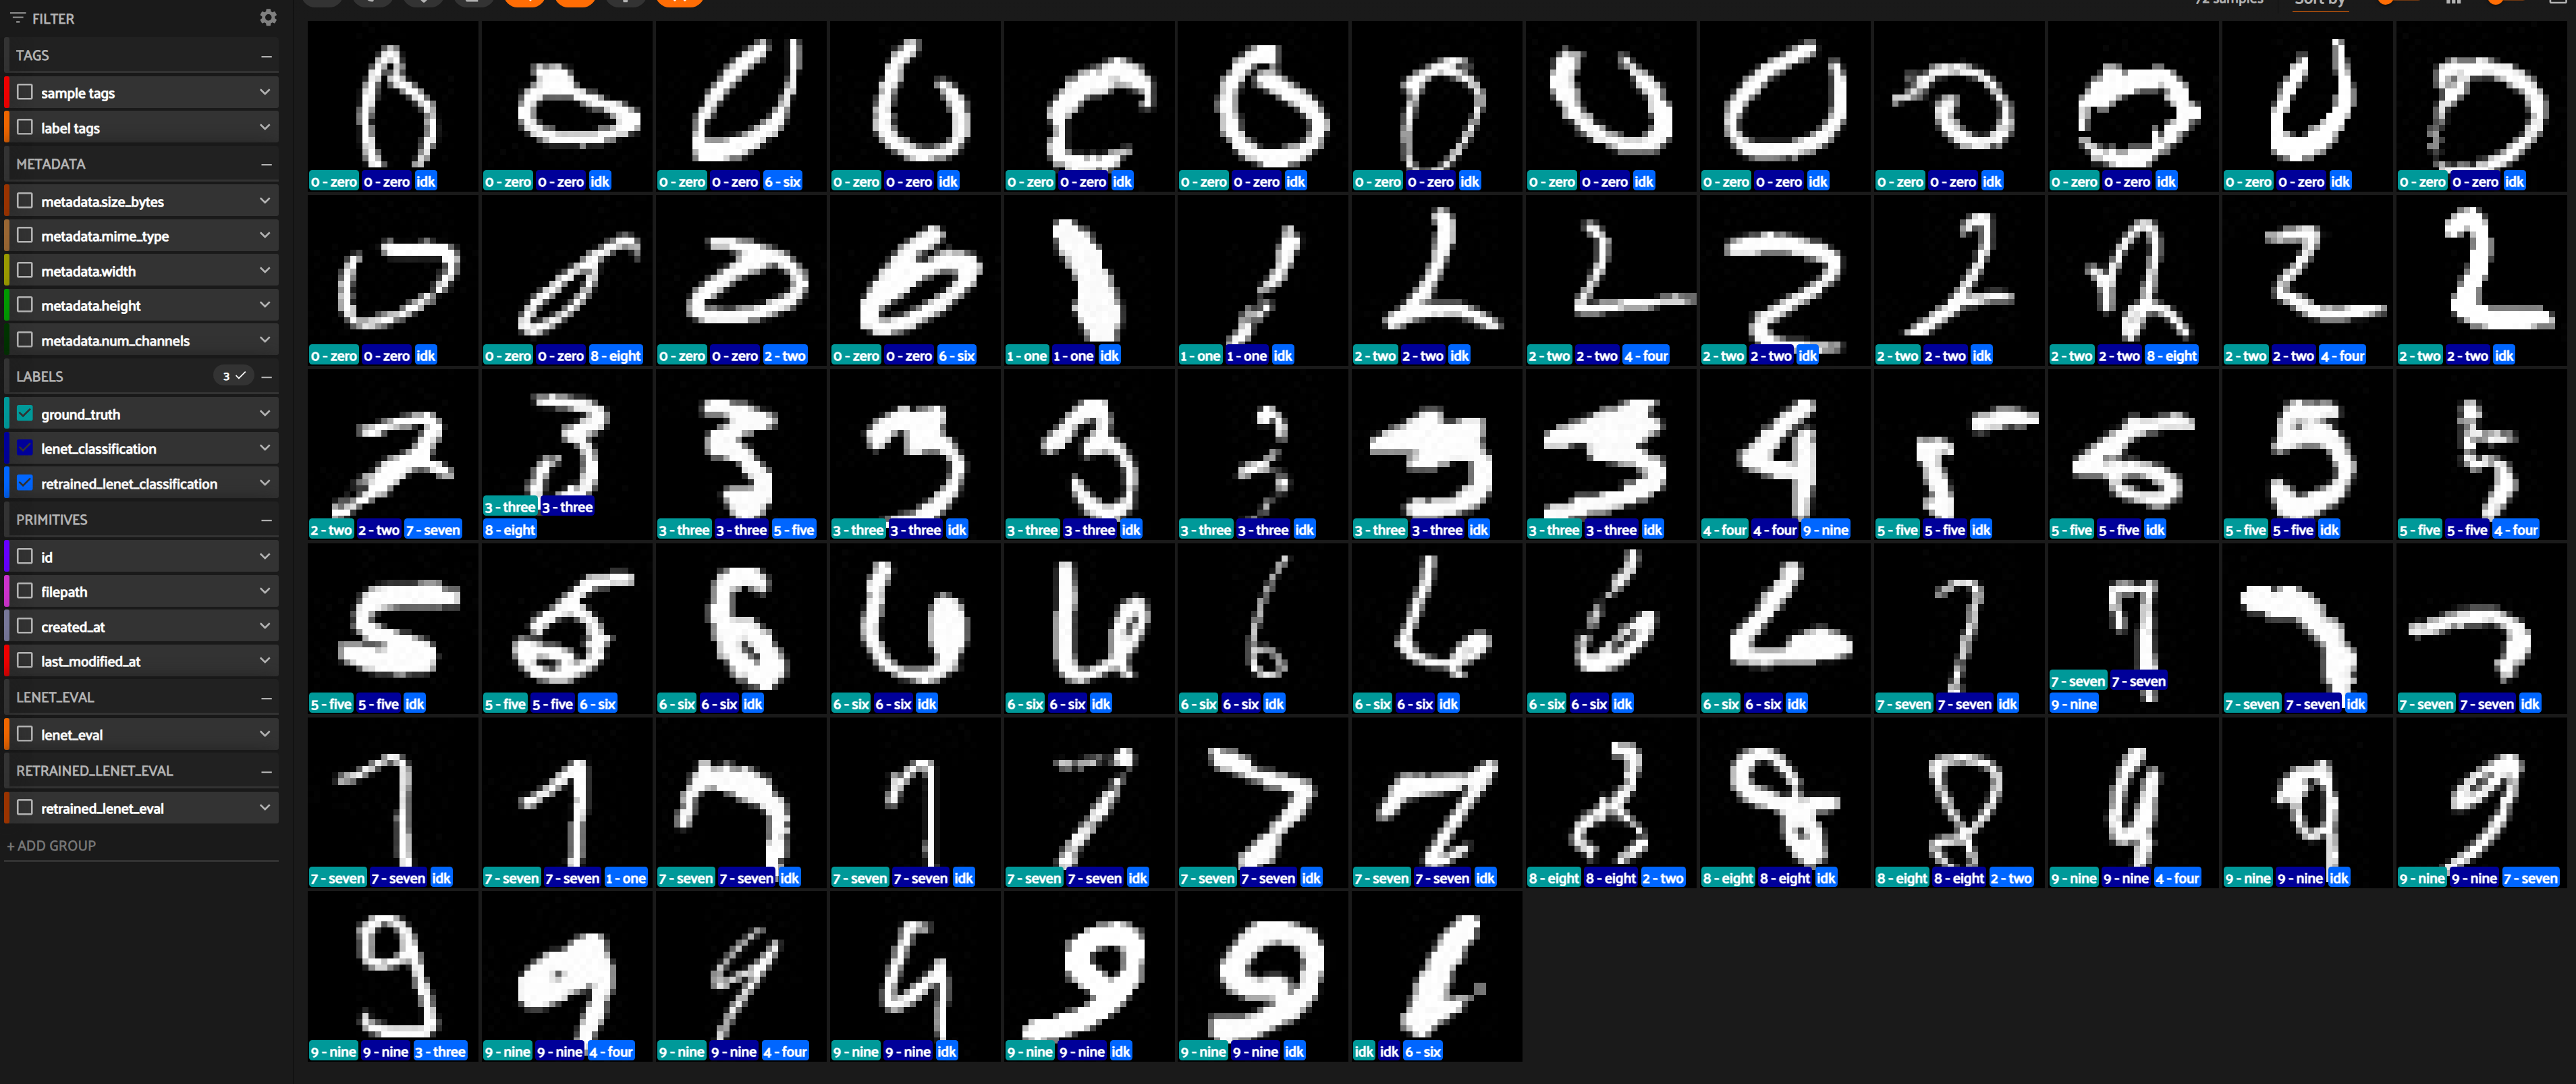

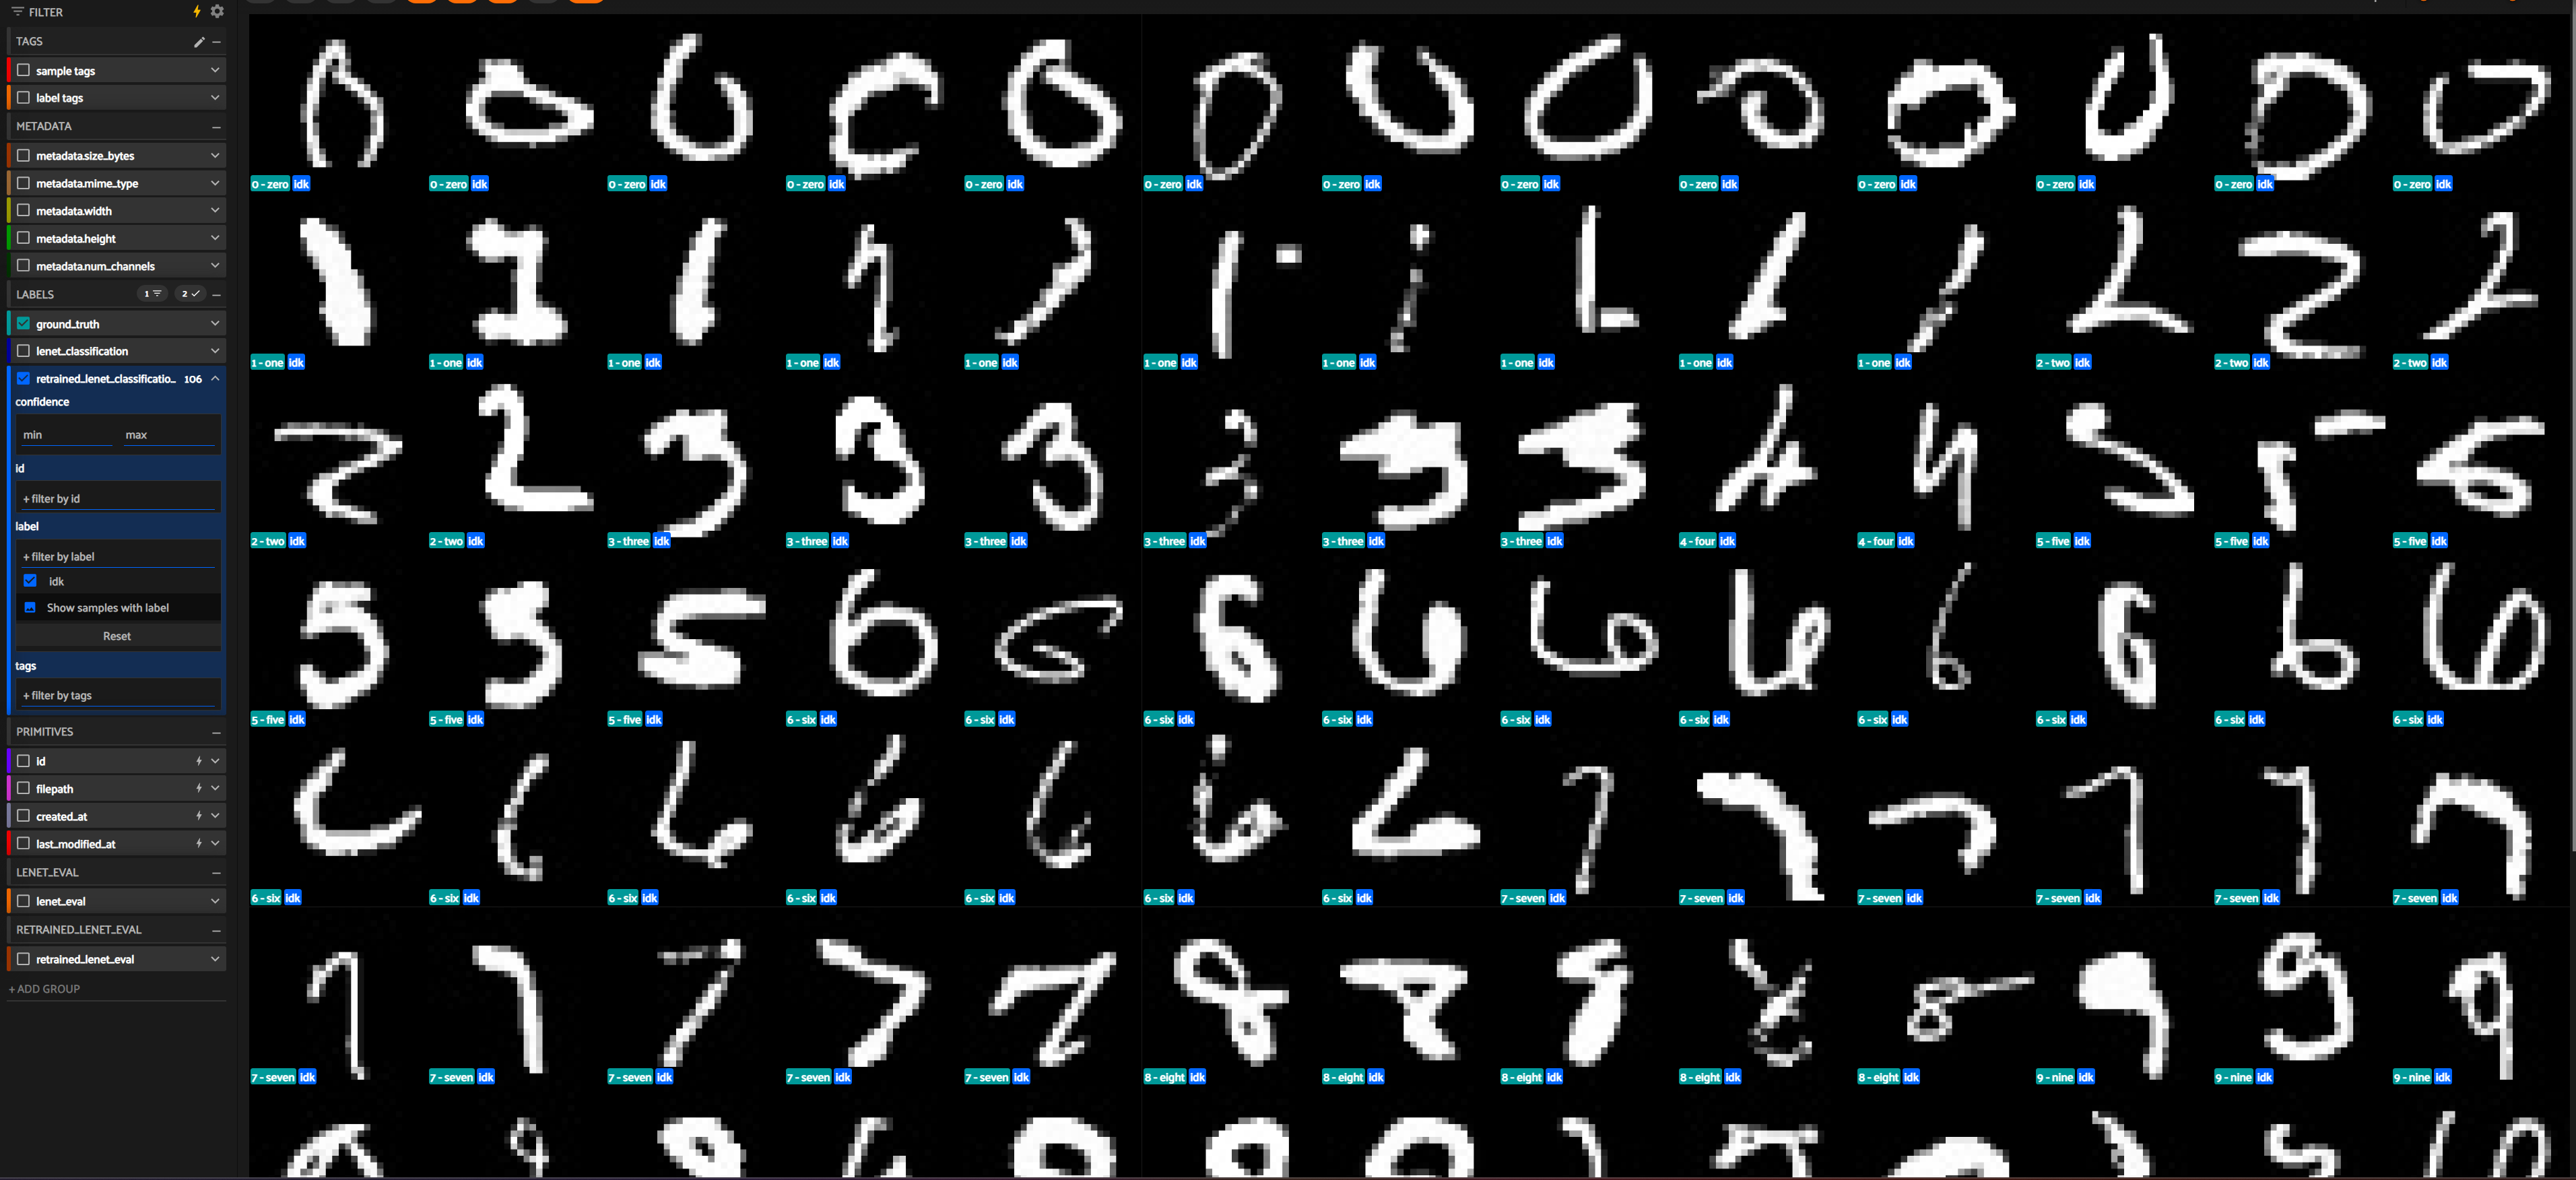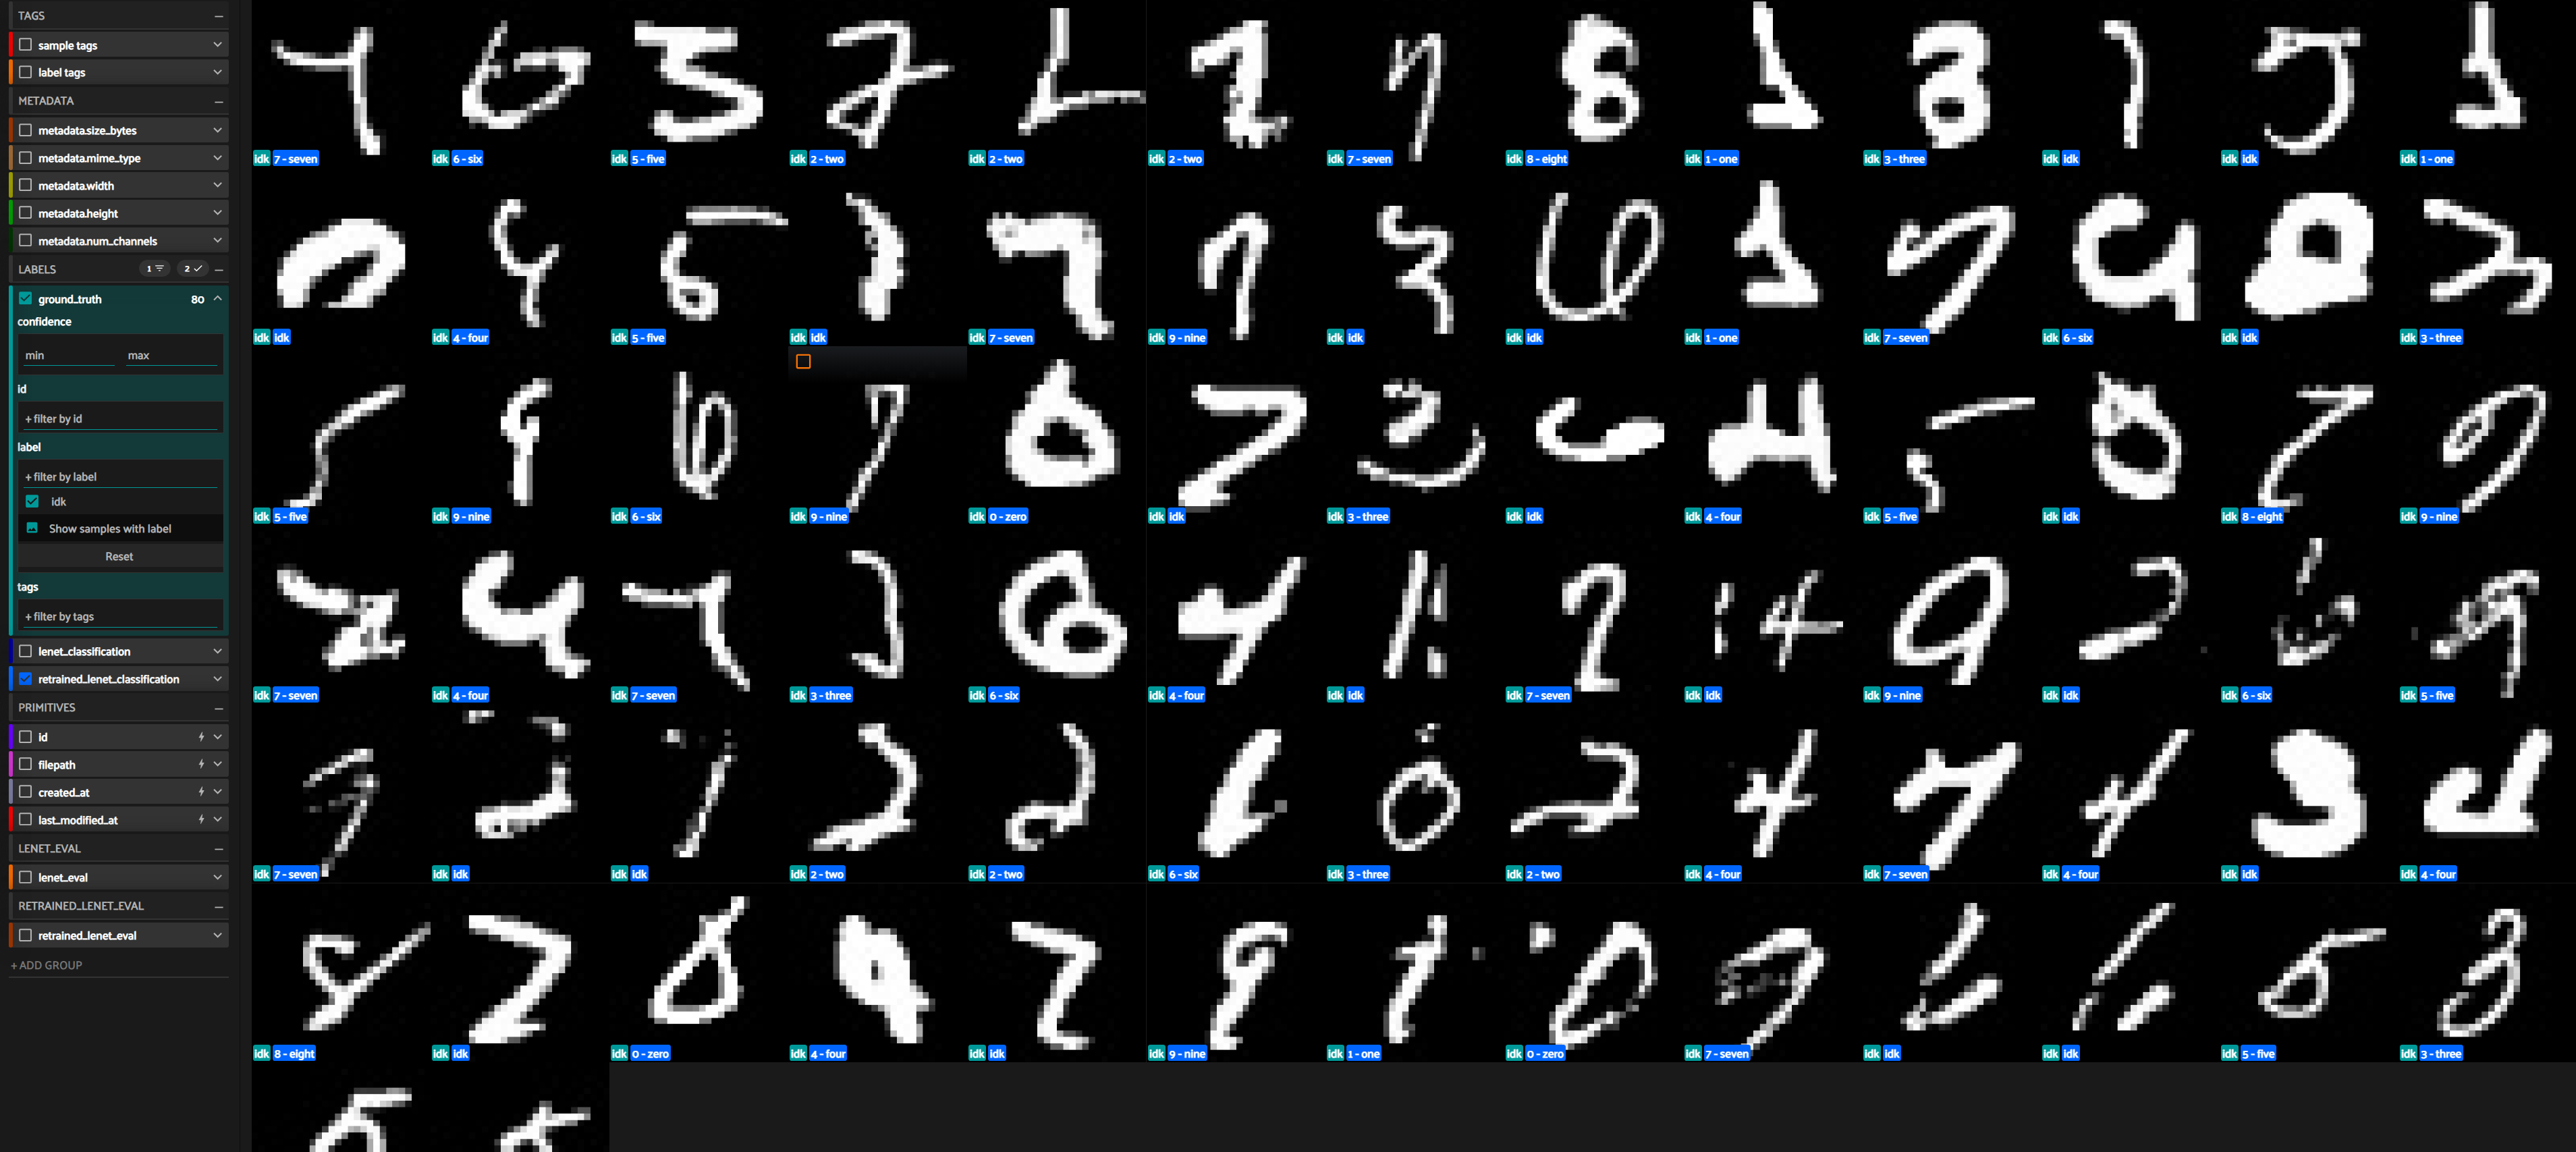